In [46]:
import numpy as np
import pandas as pd
import datetime
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [47]:
DATA_LOC = "../data/data_a.csv"
DATA_LOC_TEST = "../data/data_b.csv"

In [48]:
raw_data = pd.read_csv(DATA_LOC)
raw_data.head()
# How many dataset? Shape of dataset

time  temperature_2m_c  relative_humidity_2m_percent  \
0  2015-01-01T00:00              23.2                            83   
1  2015-01-01T01:00              22.7                            87   
2  2015-01-01T02:00              22.5                            88   
3  2015-01-01T03:00              22.6                            88   
4  2015-01-01T04:00              22.9                            87   

   dew_point_2m_c  rain_mm  snowfall_cm  cloud_cover_percent  \
0            20.1      1.2          0.0                  100   
1            20.5      3.1          0.0                  100   
2            20.4      3.3          0.0                  100   
3            20.6      1.3          0.0                  100   
4            20.5      0.5          0.0                  100   

   wind_speed_10m_kph  wind_direction_10m_degrees  wind_gusts_10m_kph  
0                26.0                          37                70.9  
1                26.6                          36                75.2  
2                26.2                          37                77.0  
3                27.3                          36                78.1  
4                28.1                          36                72.7

In [49]:
# Just a bit of clean up for the data
def clean_and_reindex(data):
    data["date_time"] = pd.to_datetime(data["time"])
    data = data.drop(["time"], axis=1)
    data.set_index("date_time", inplace=True) 
    return data.sort_index()
    
weather_data = clean_and_reindex(raw_data.copy())
weather_data.head()

temperature_2m_c  relative_humidity_2m_percent  \
date_time                                                             
2015-01-01 00:00:00              23.2                            83   
2015-01-01 01:00:00              22.7                            87   
2015-01-01 02:00:00              22.5                            88   
2015-01-01 03:00:00              22.6                            88   
2015-01-01 04:00:00              22.9                            87   

                     dew_point_2m_c  rain_mm  snowfall_cm  \
date_time                                                   
2015-01-01 00:00:00            20.1      1.2          0.0   
2015-01-01 01:00:00            20.5      3.1          0.0   
2015-01-01 02:00:00            20.4      3.3          0.0   
2015-01-01 03:00:00            20.6      1.3          0.0   
2015-01-01 04:00:00            20.5      0.5          0.0   

                     cloud_cover_percent  wind_speed_10m_kph  \
date_time                                                      
2015-01-01 00:00:00                  100                26.0   
2015-01-01 01:00:00                  100                26.6   
2015-01-01 02:00:00                  100                26.2   
2015-01-01 03:00:00                  100                27.3   
2015-01-01 04:00:00                  100                28.1   

                     wind_direction_10m_degrees  wind_gusts_10m_kph  
date_time                                                            
2015-01-01 00:00:00                          37                70.9  
2015-01-01 01:00:00                          36                75.2  
2015-01-01 02:00:00                          37                77.0  
2015-01-01 03:00:00                          36                78.1  
2015-01-01 04:00:00                          36                72.7

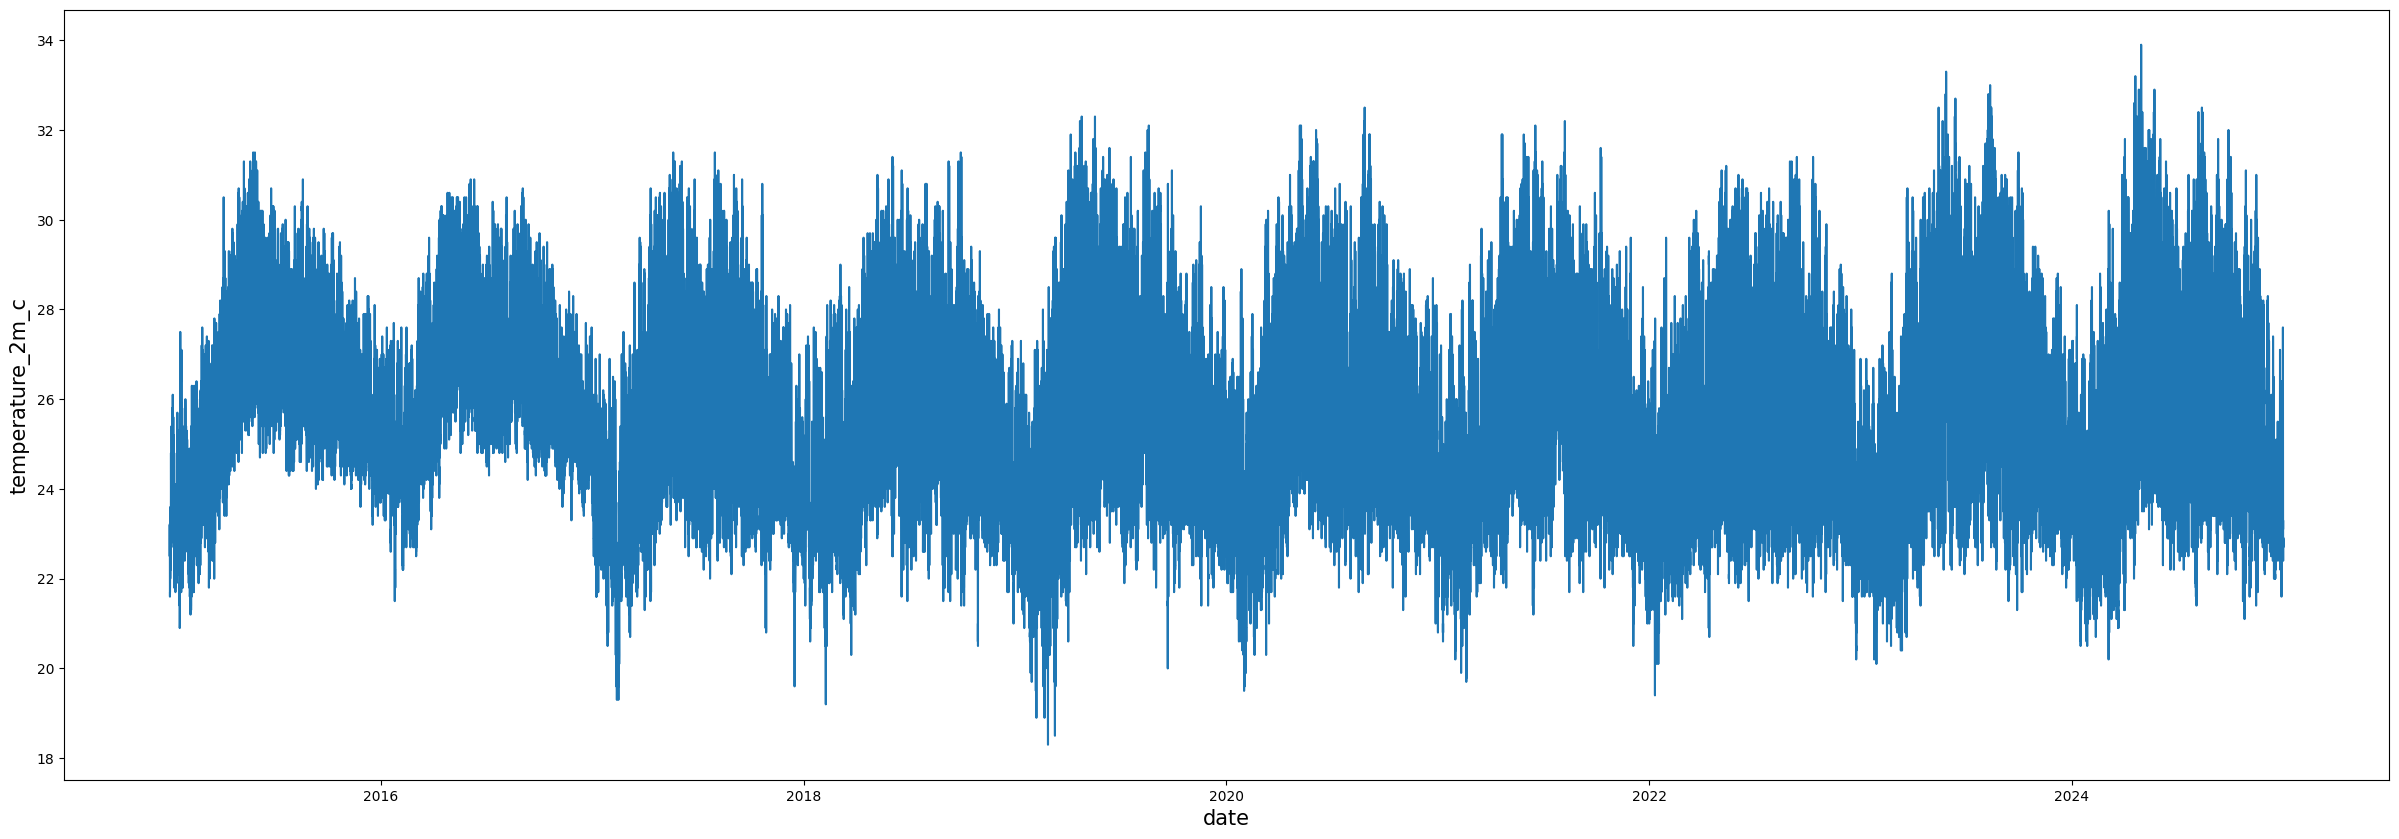

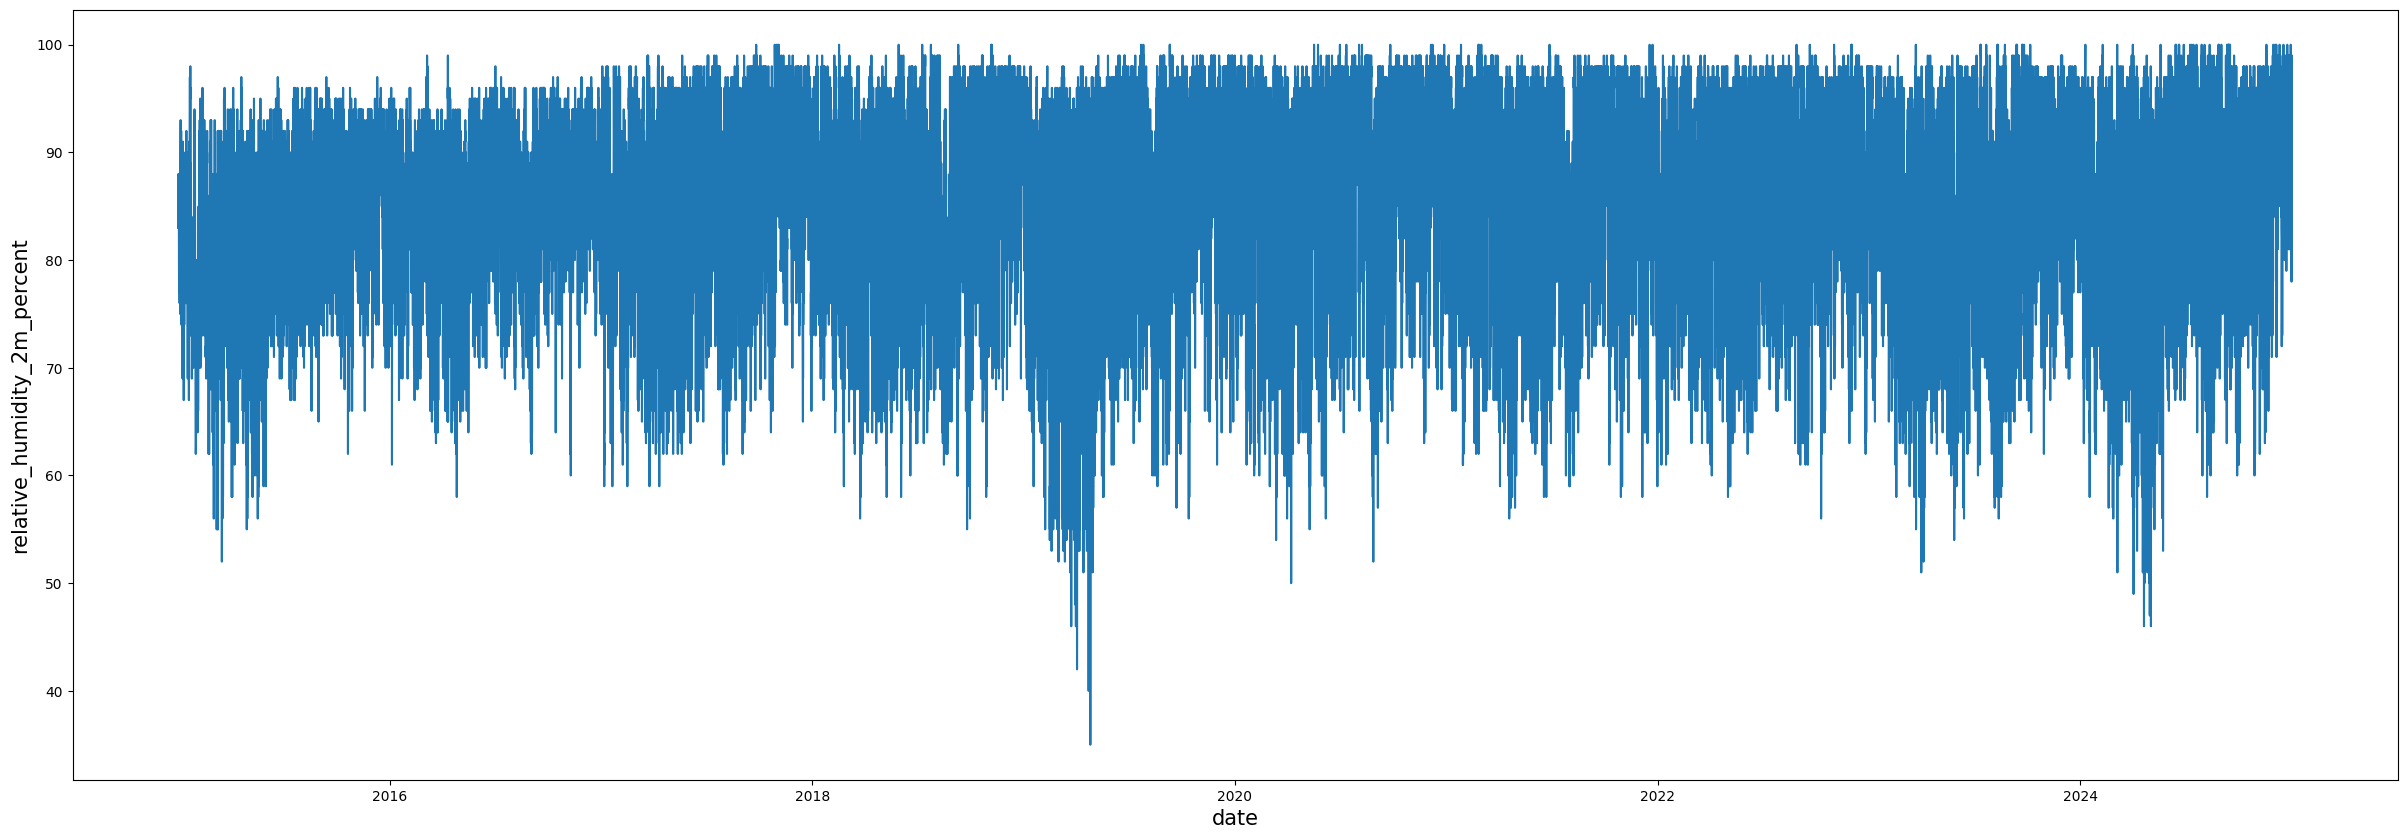

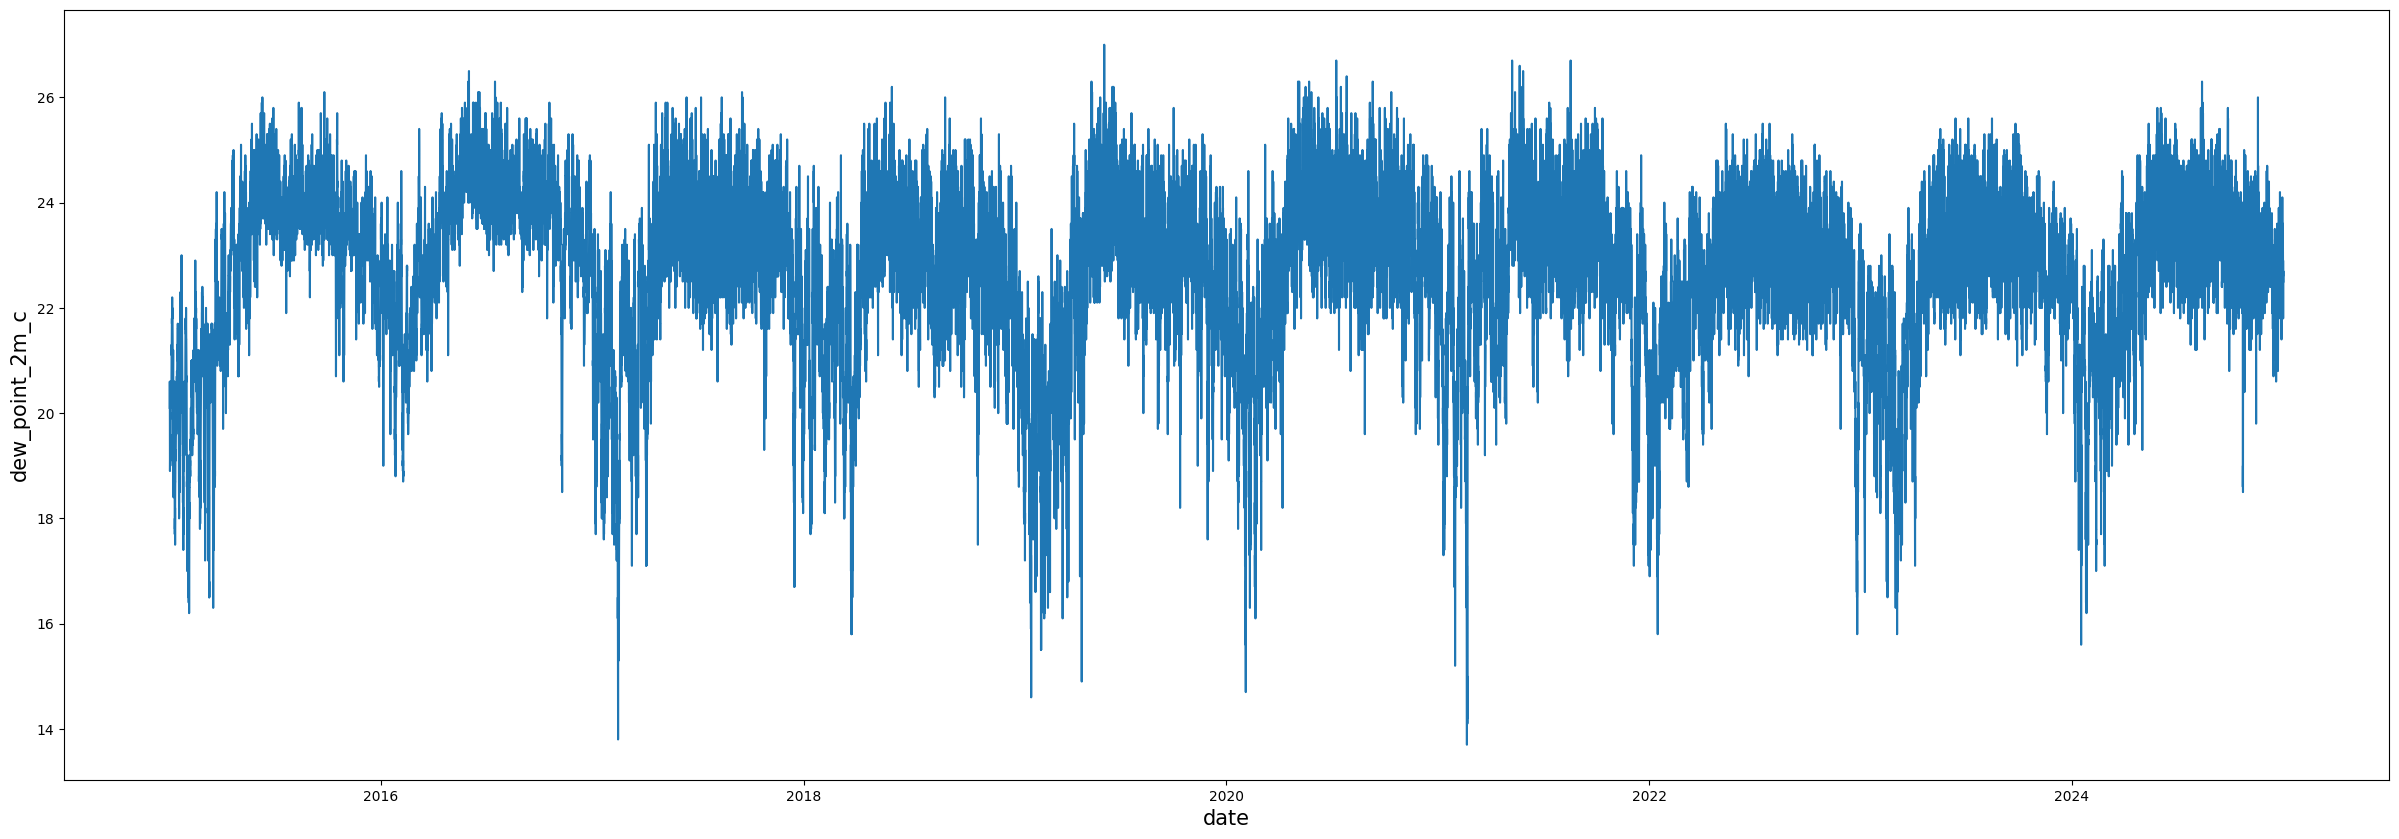

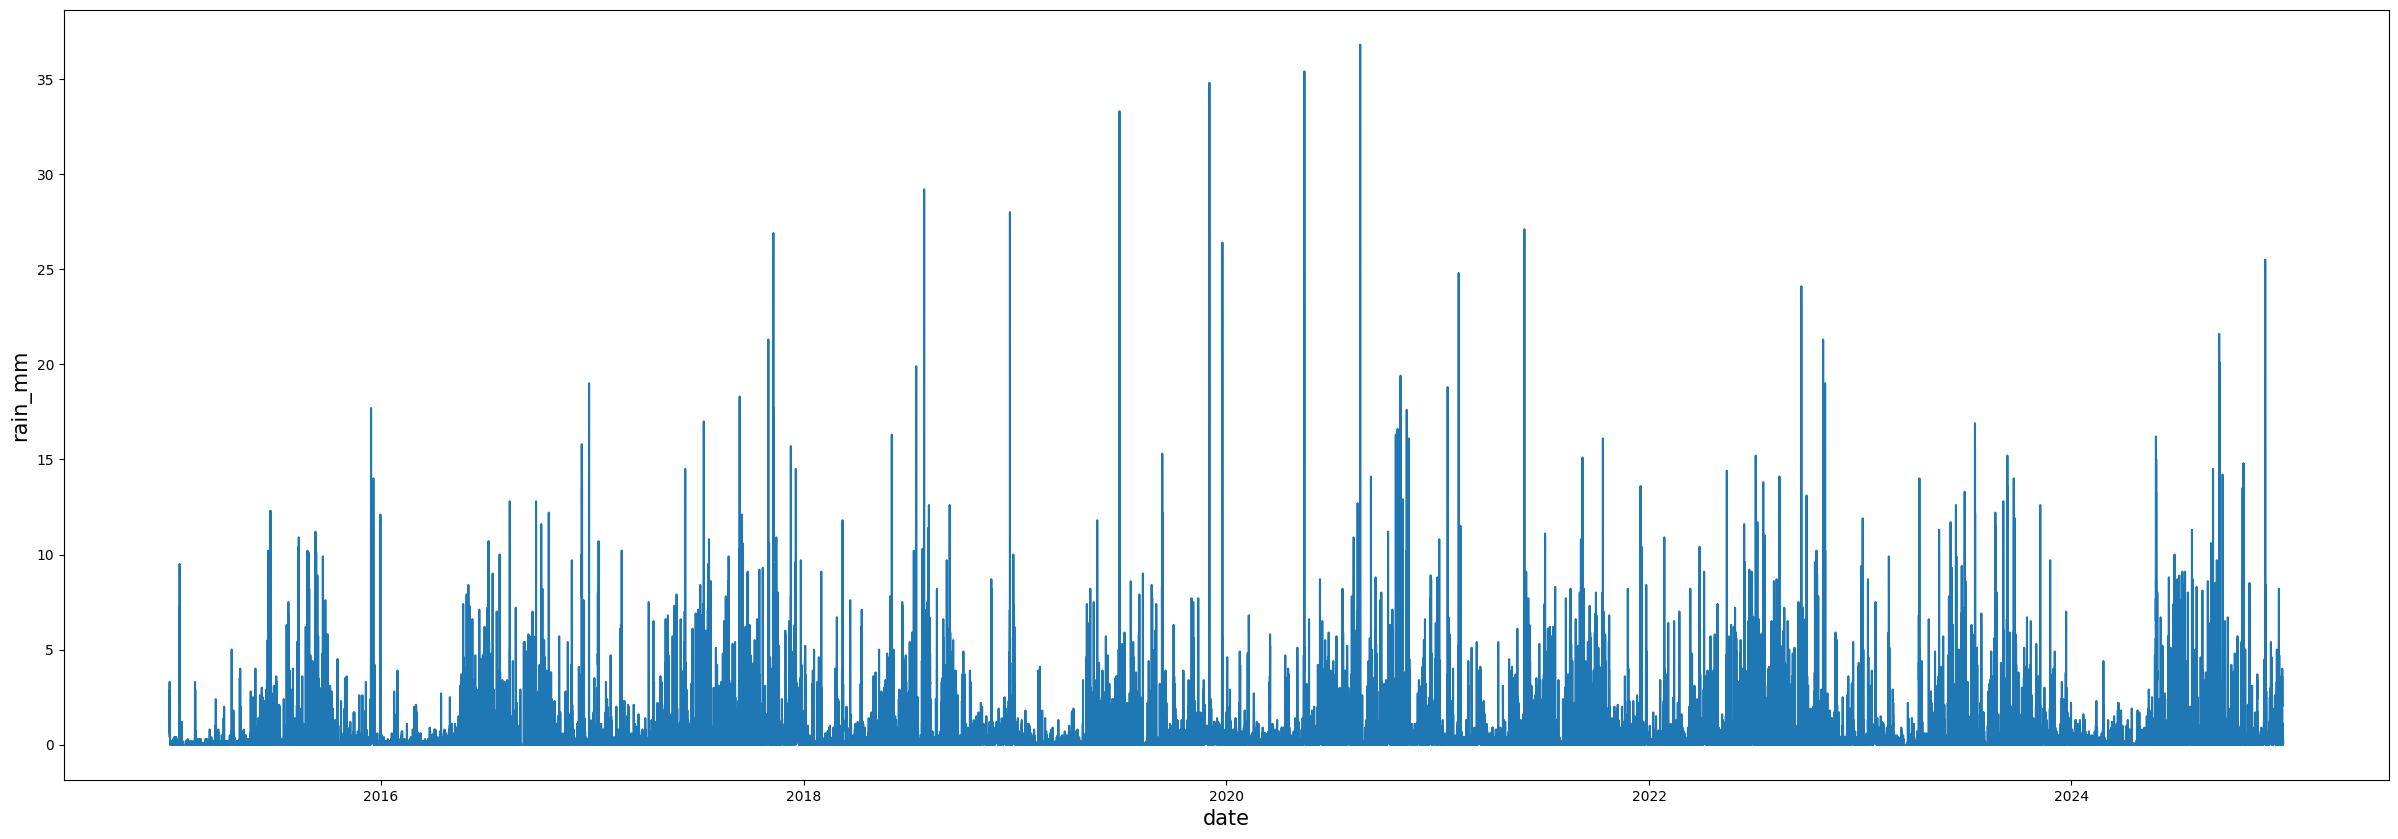

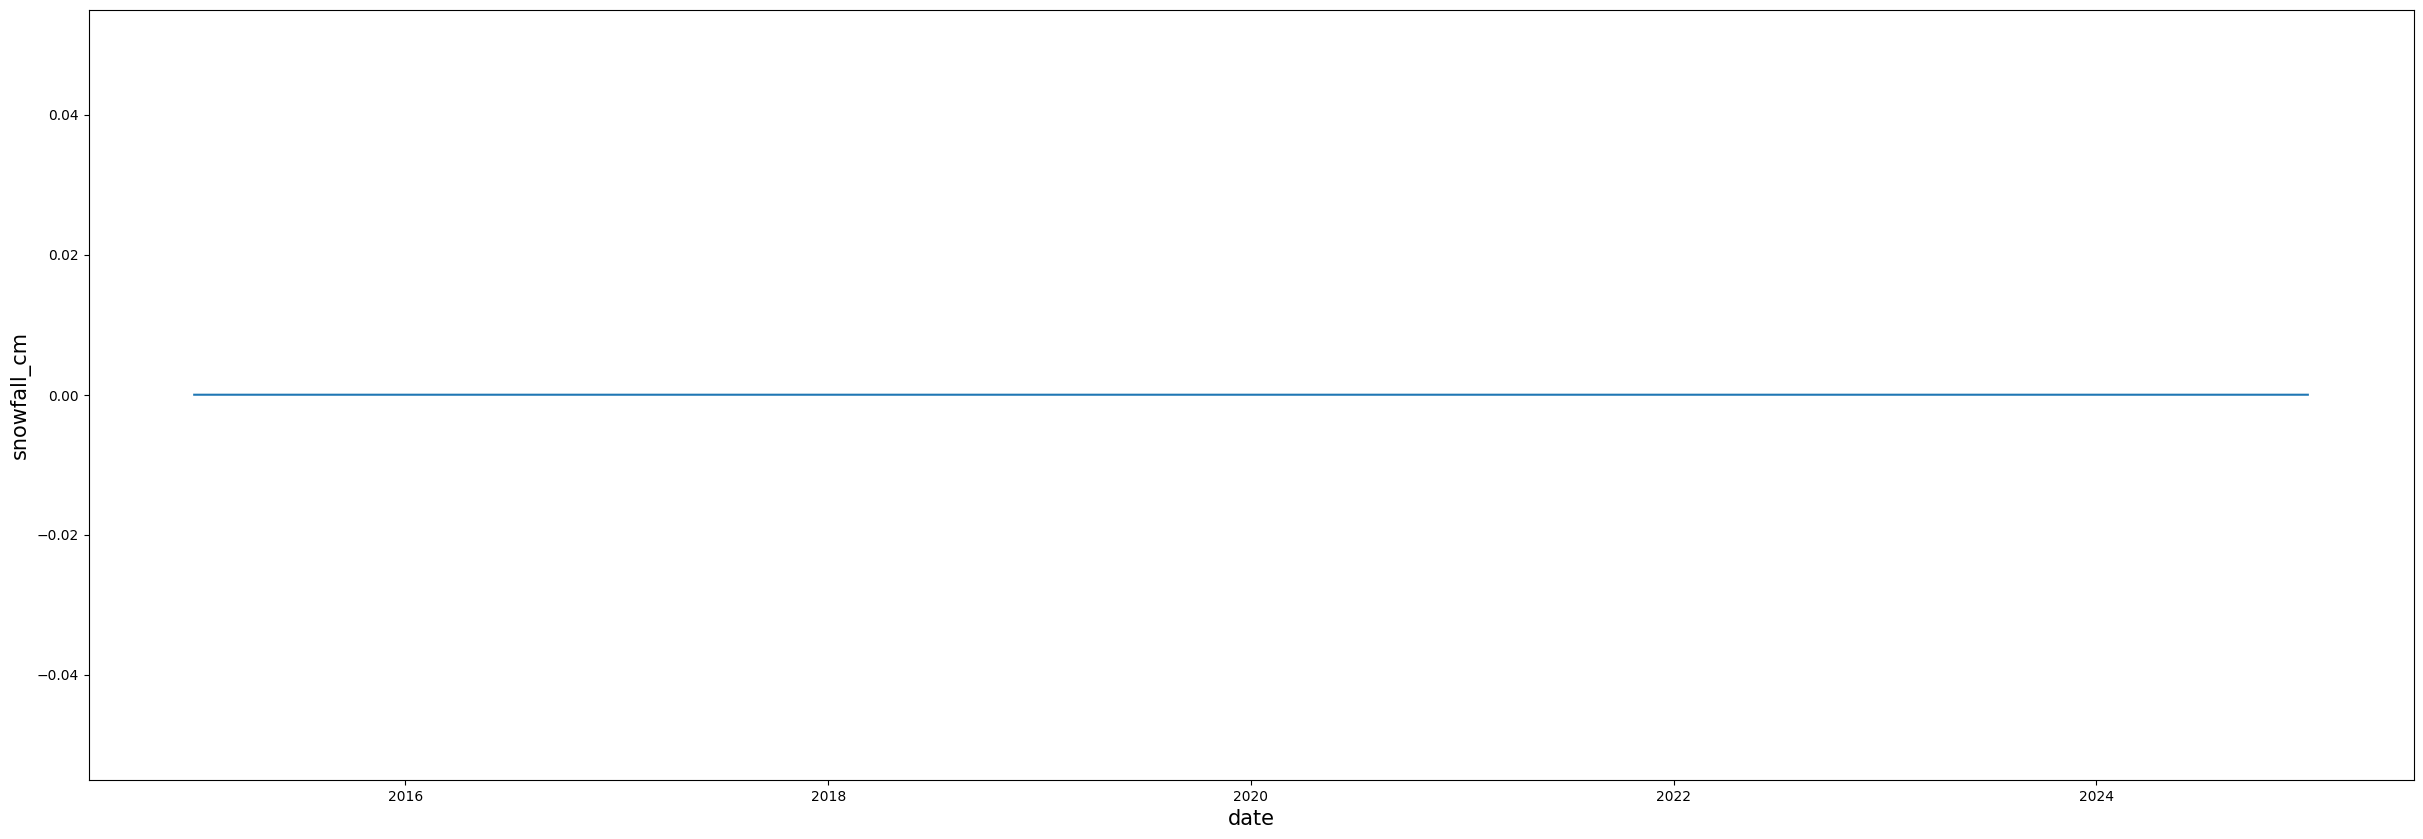

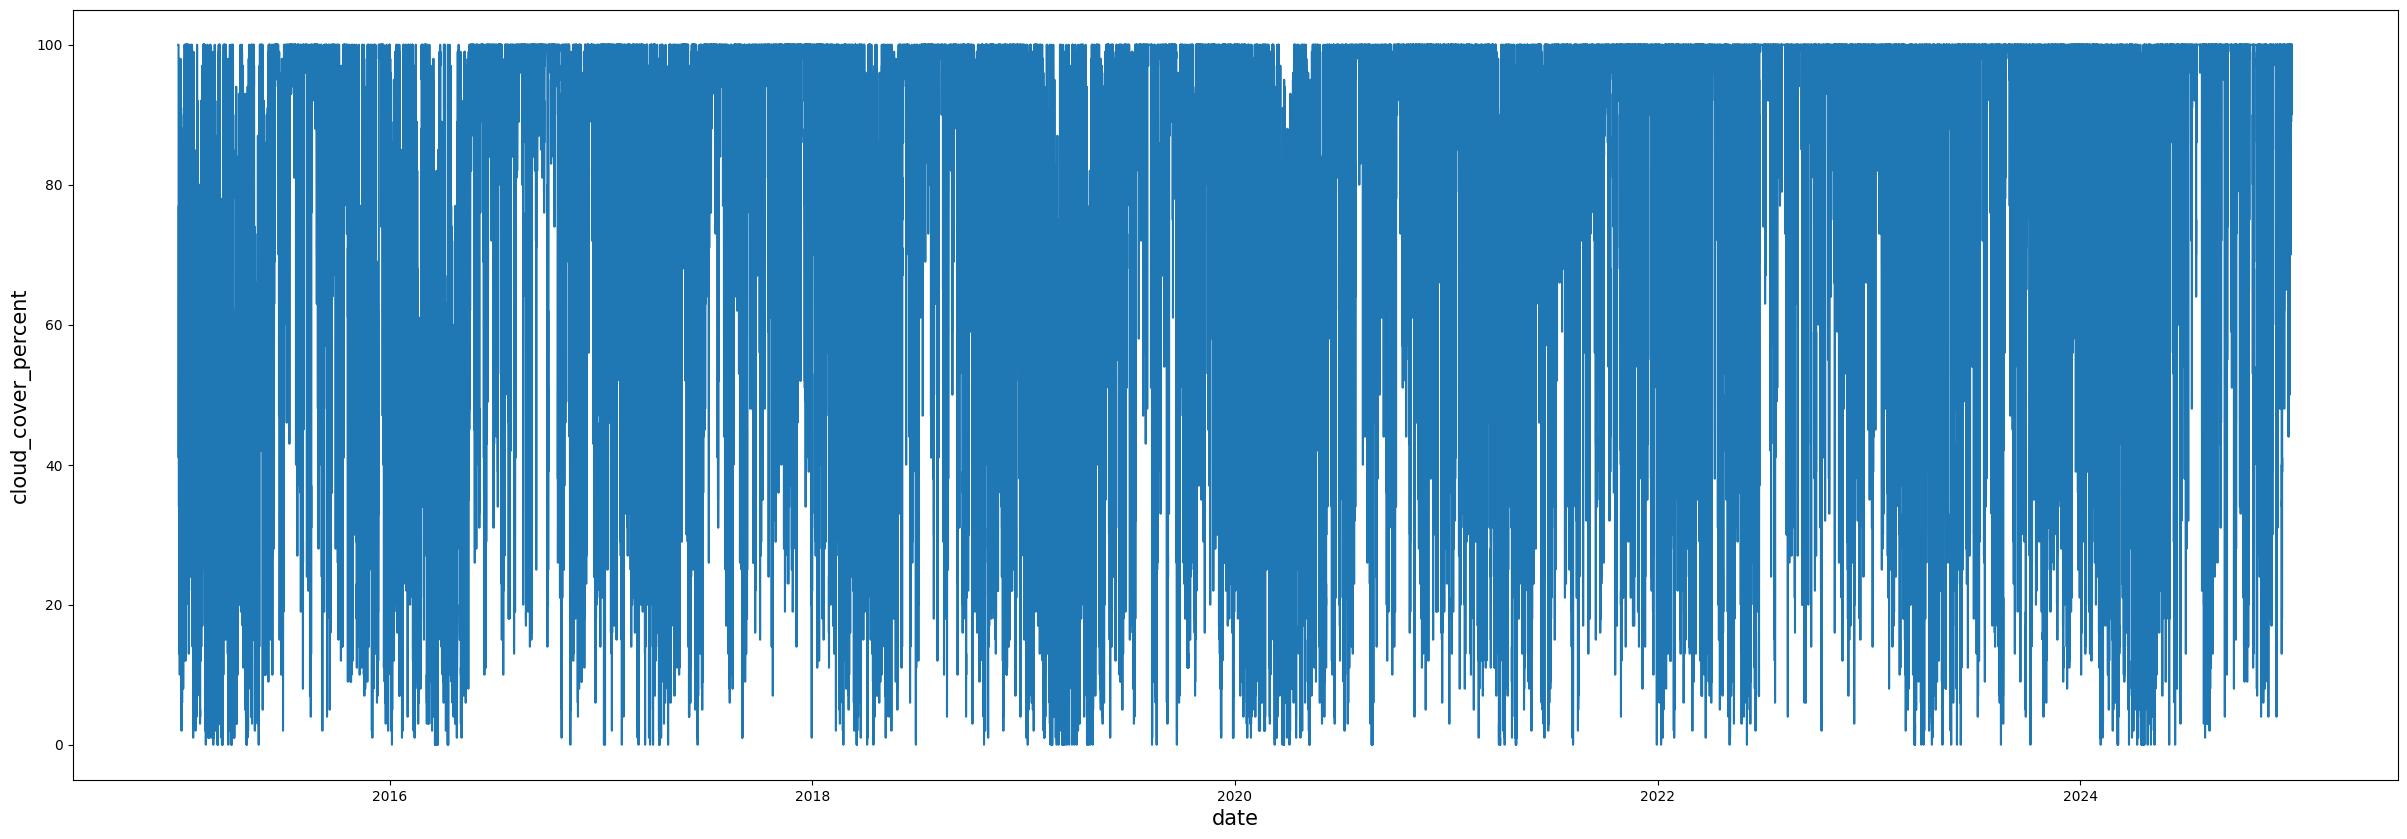

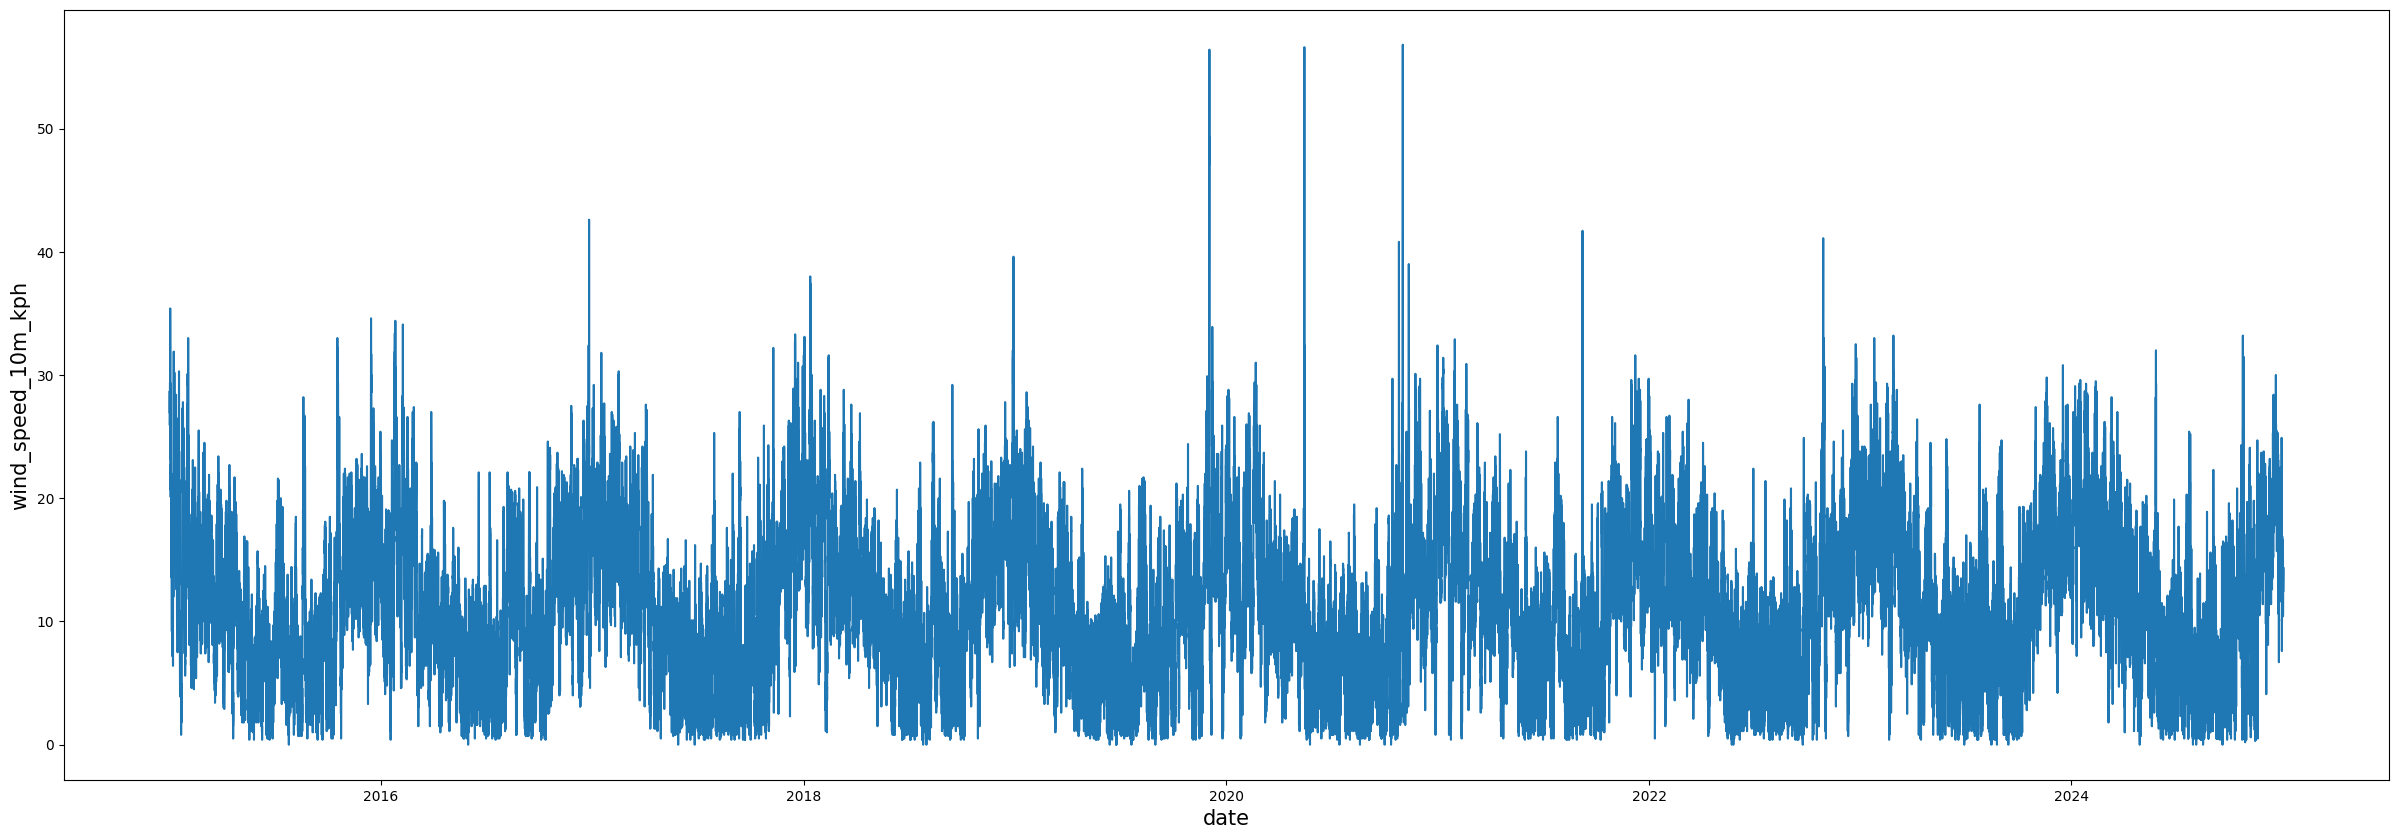

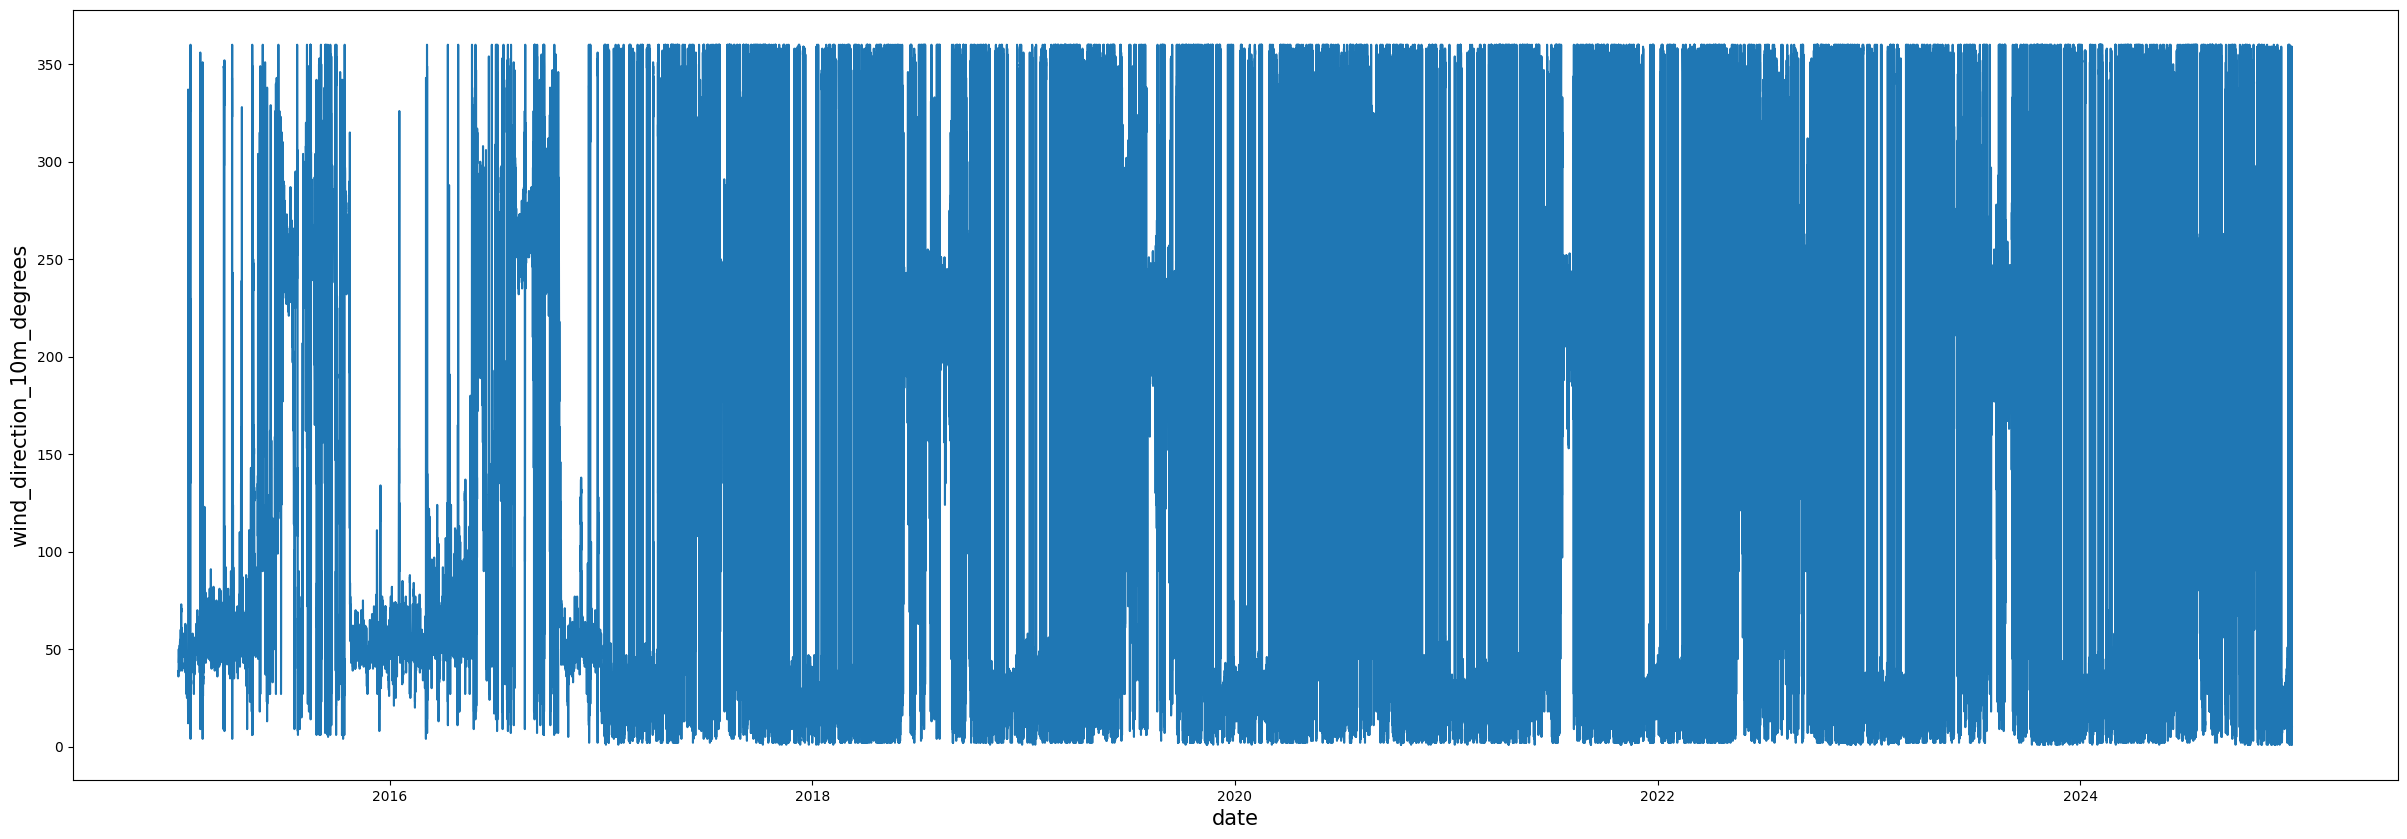

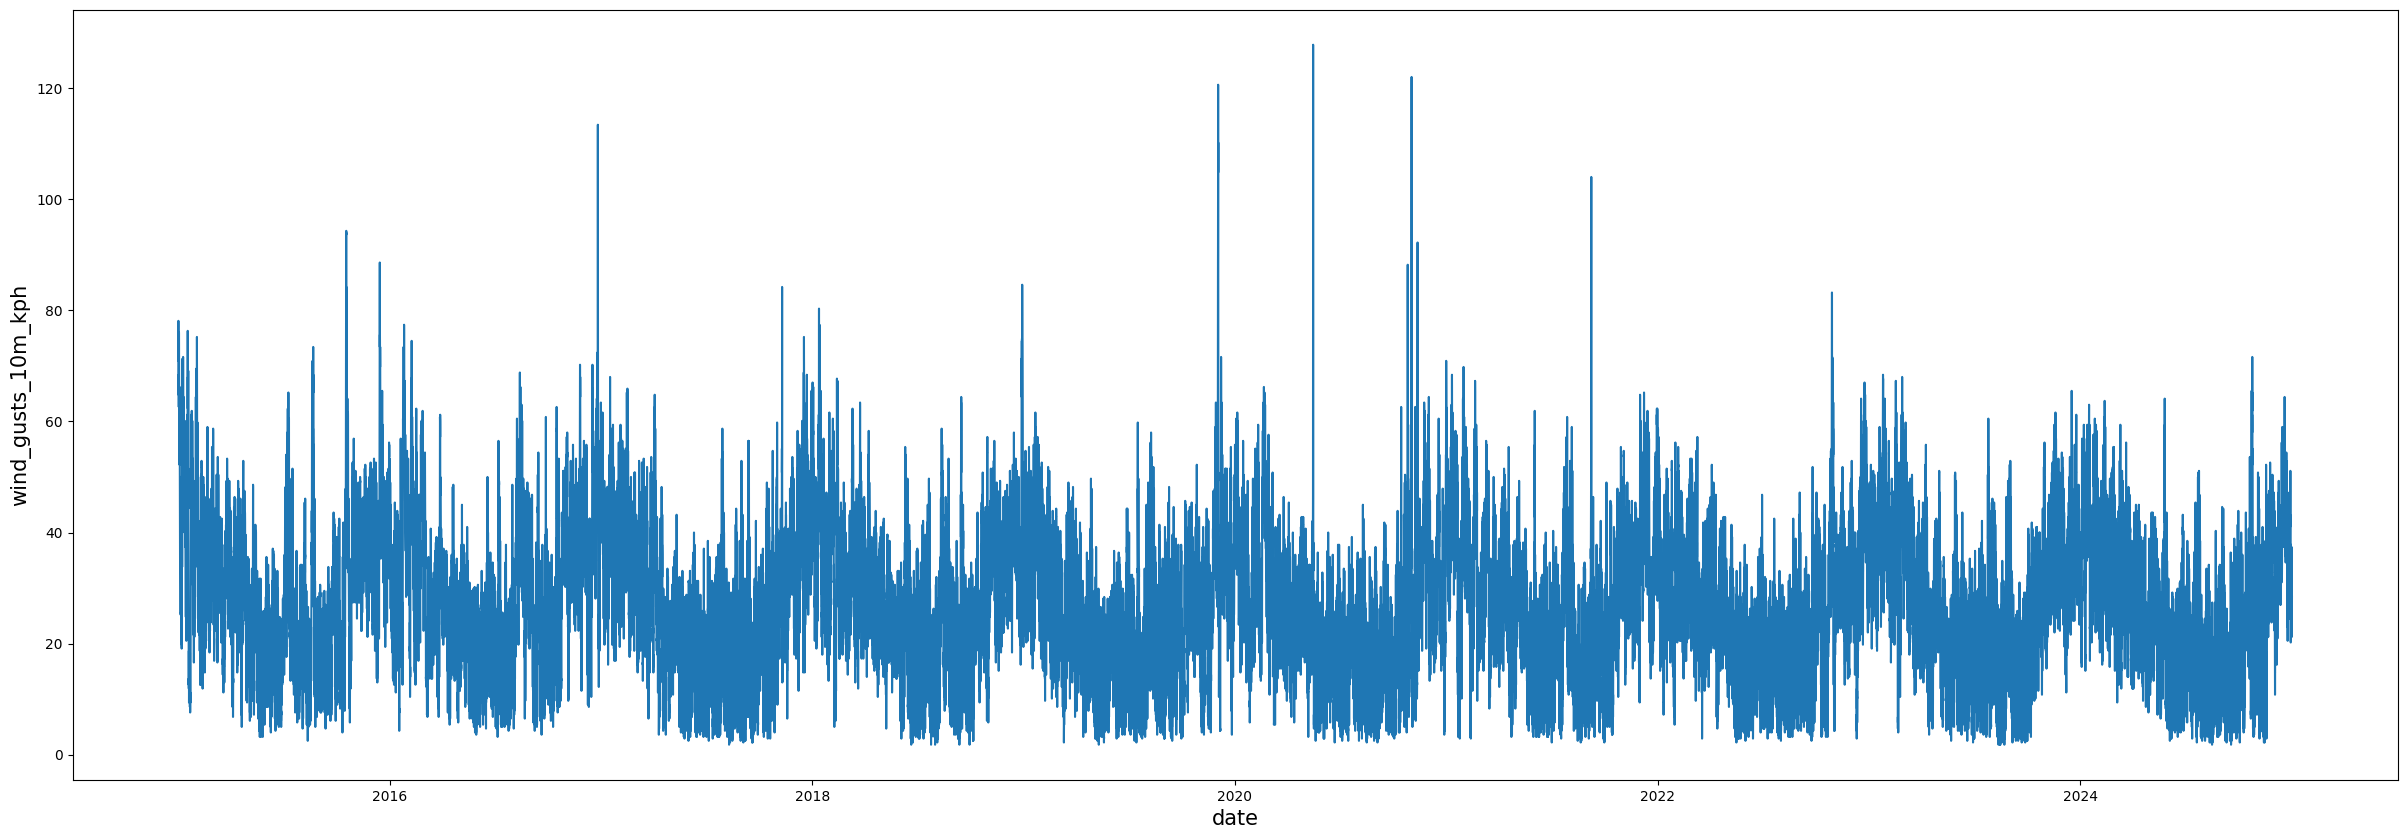

In [50]:
# Visualise the data
def visualize(data):
    for col in data.columns:
        plt.figure(figsize=(30, 10))
        plt.plot(data.index, data[col])
        plt.xlabel("date", fontsize=15)
        plt.ylabel(col, fontsize=15)
        plt.show()

visualize(weather_data)

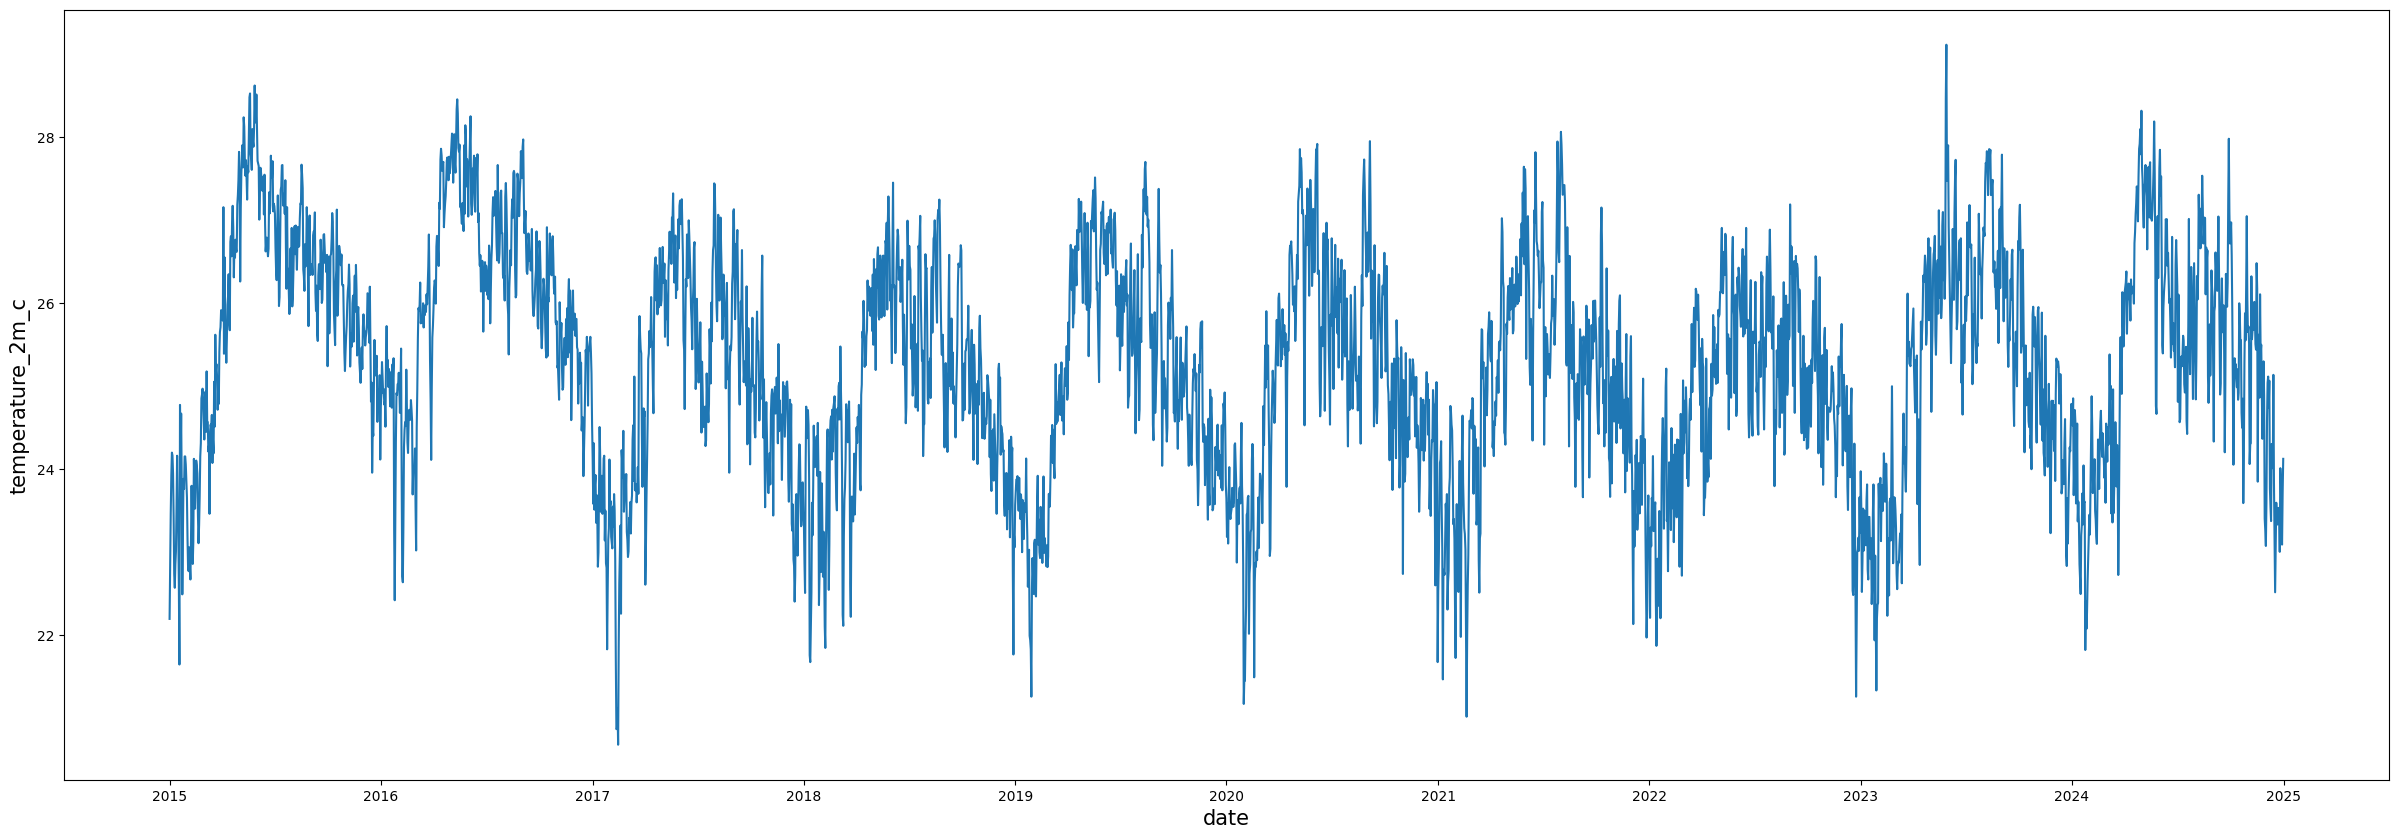

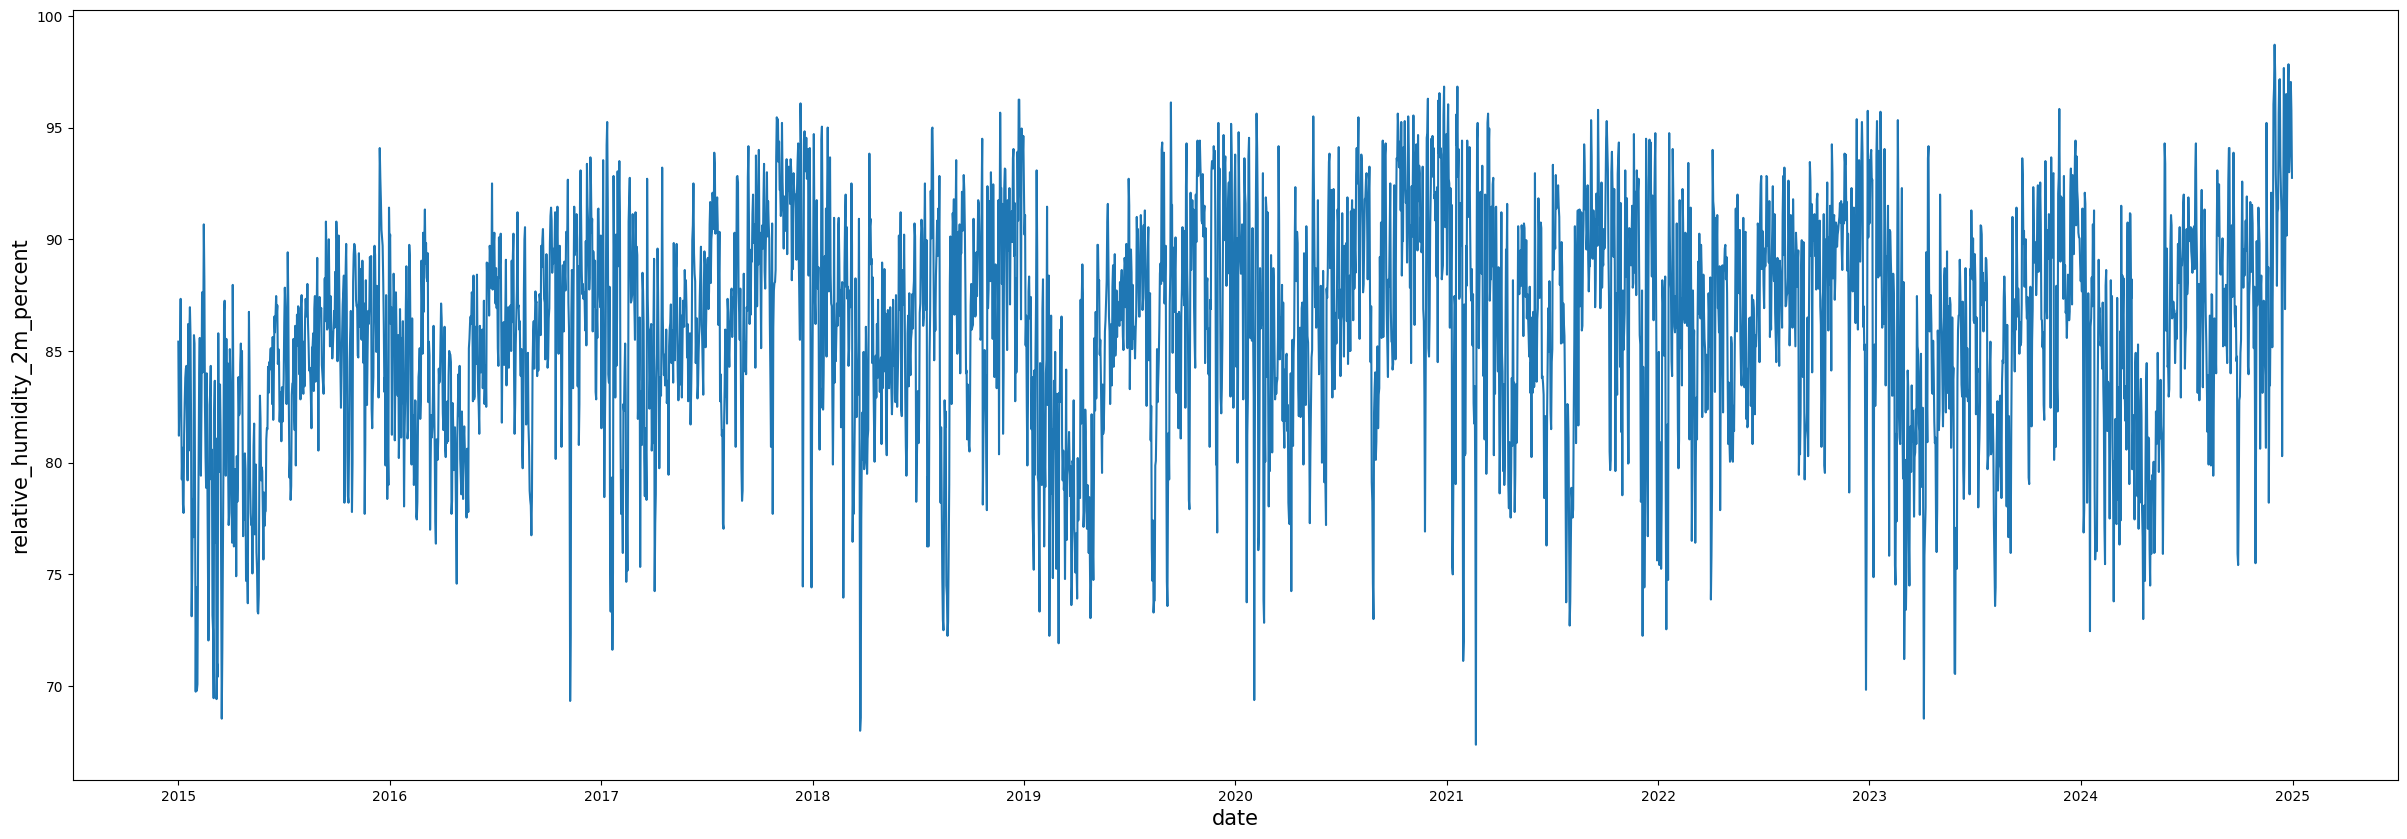

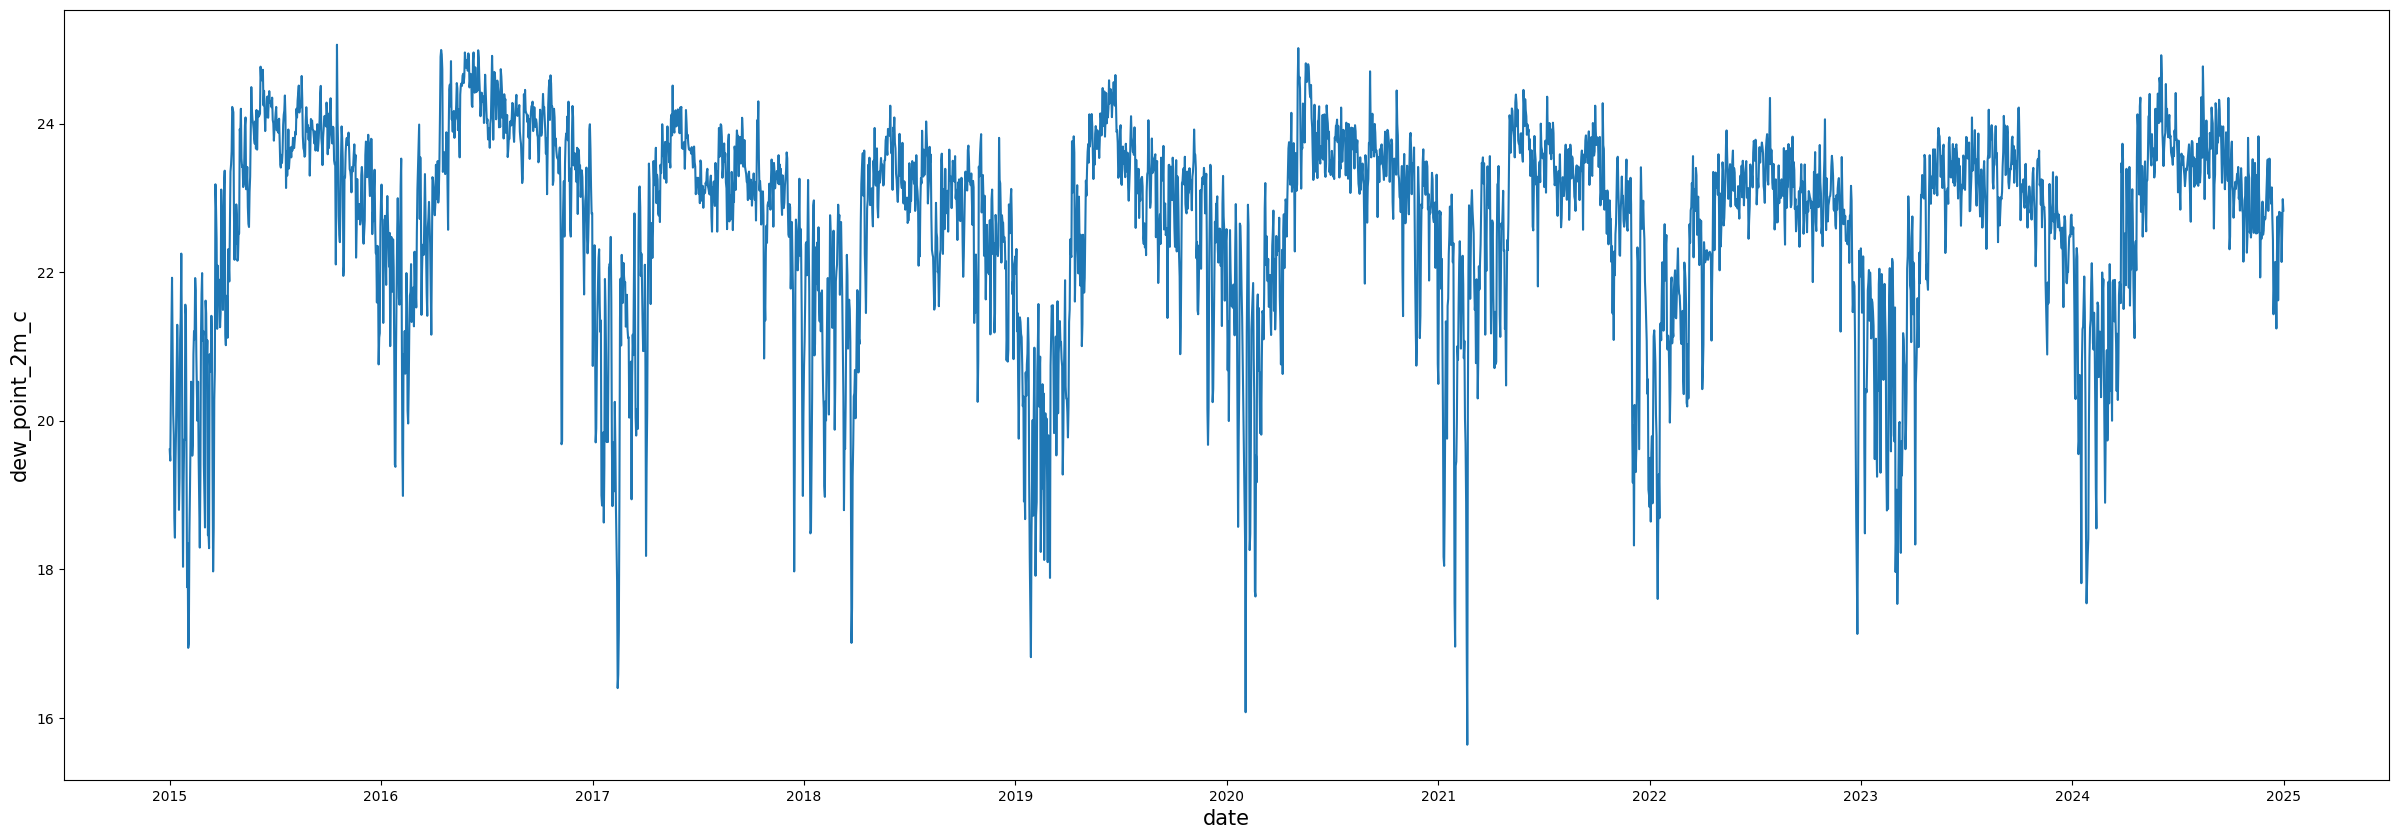

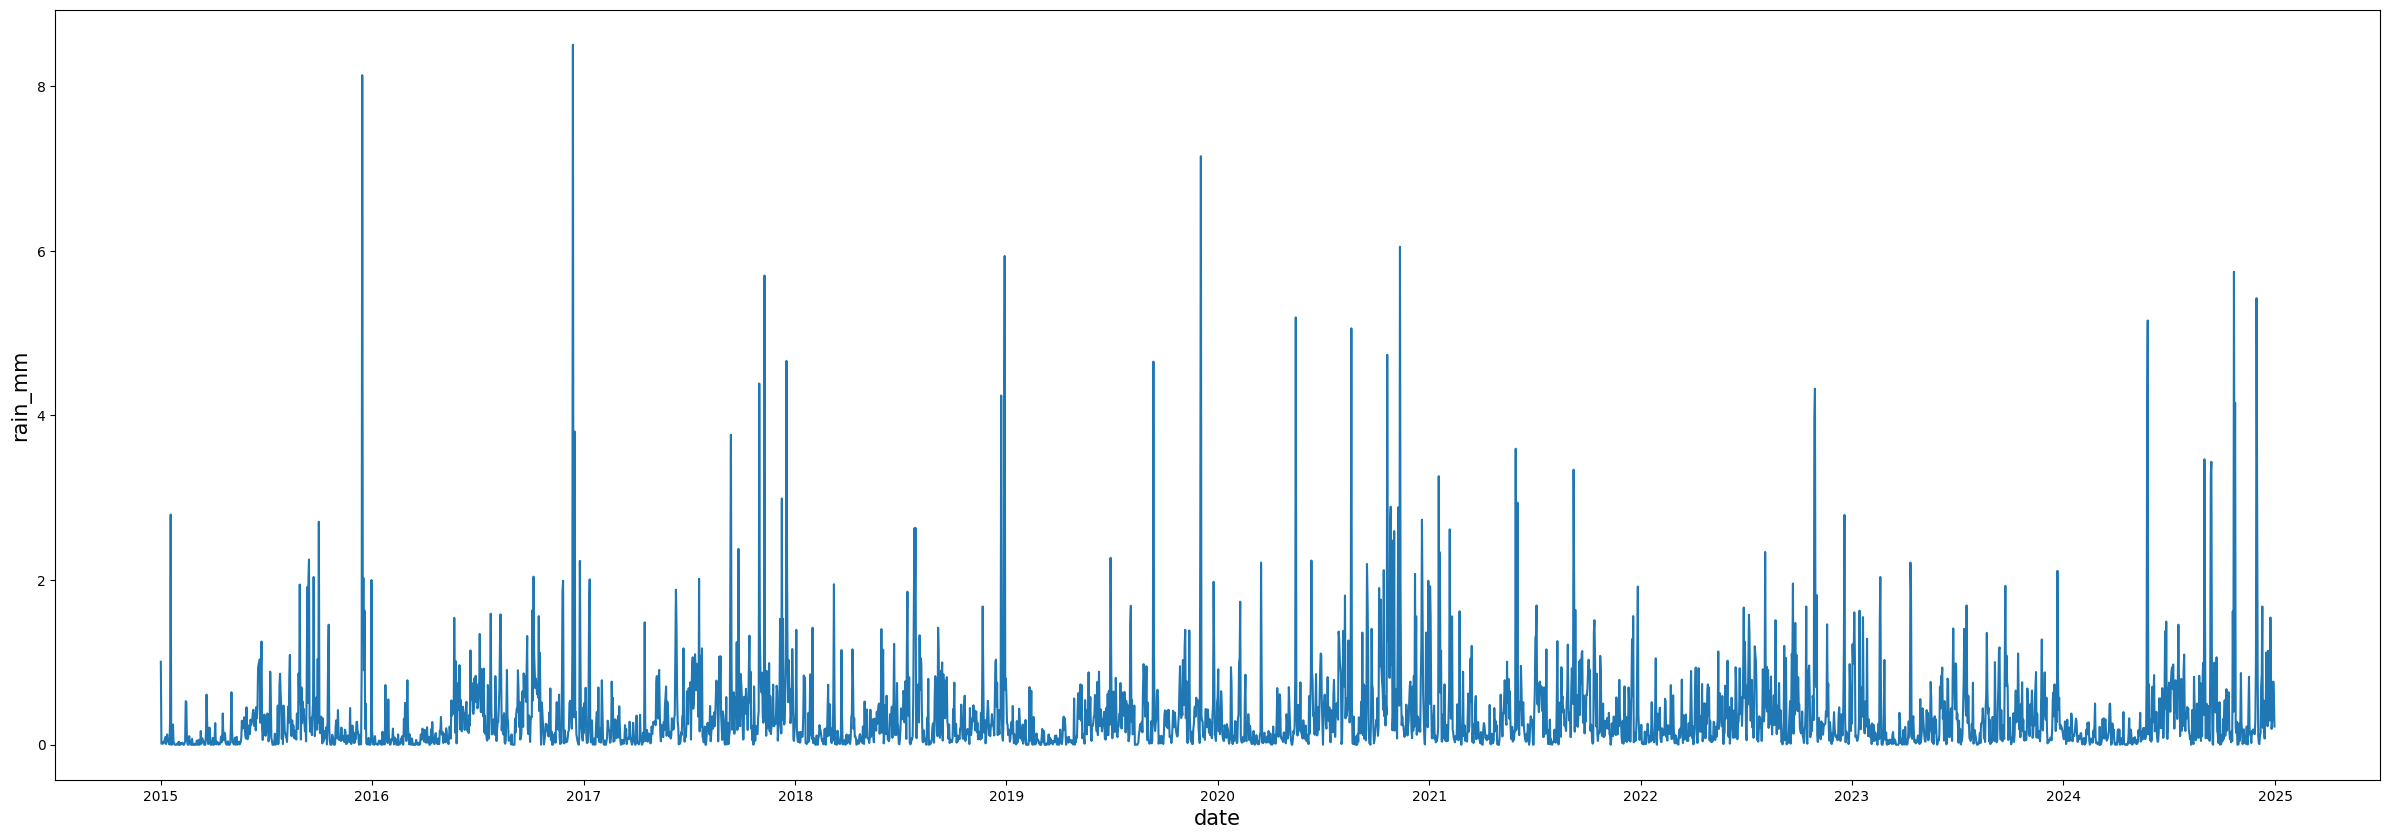

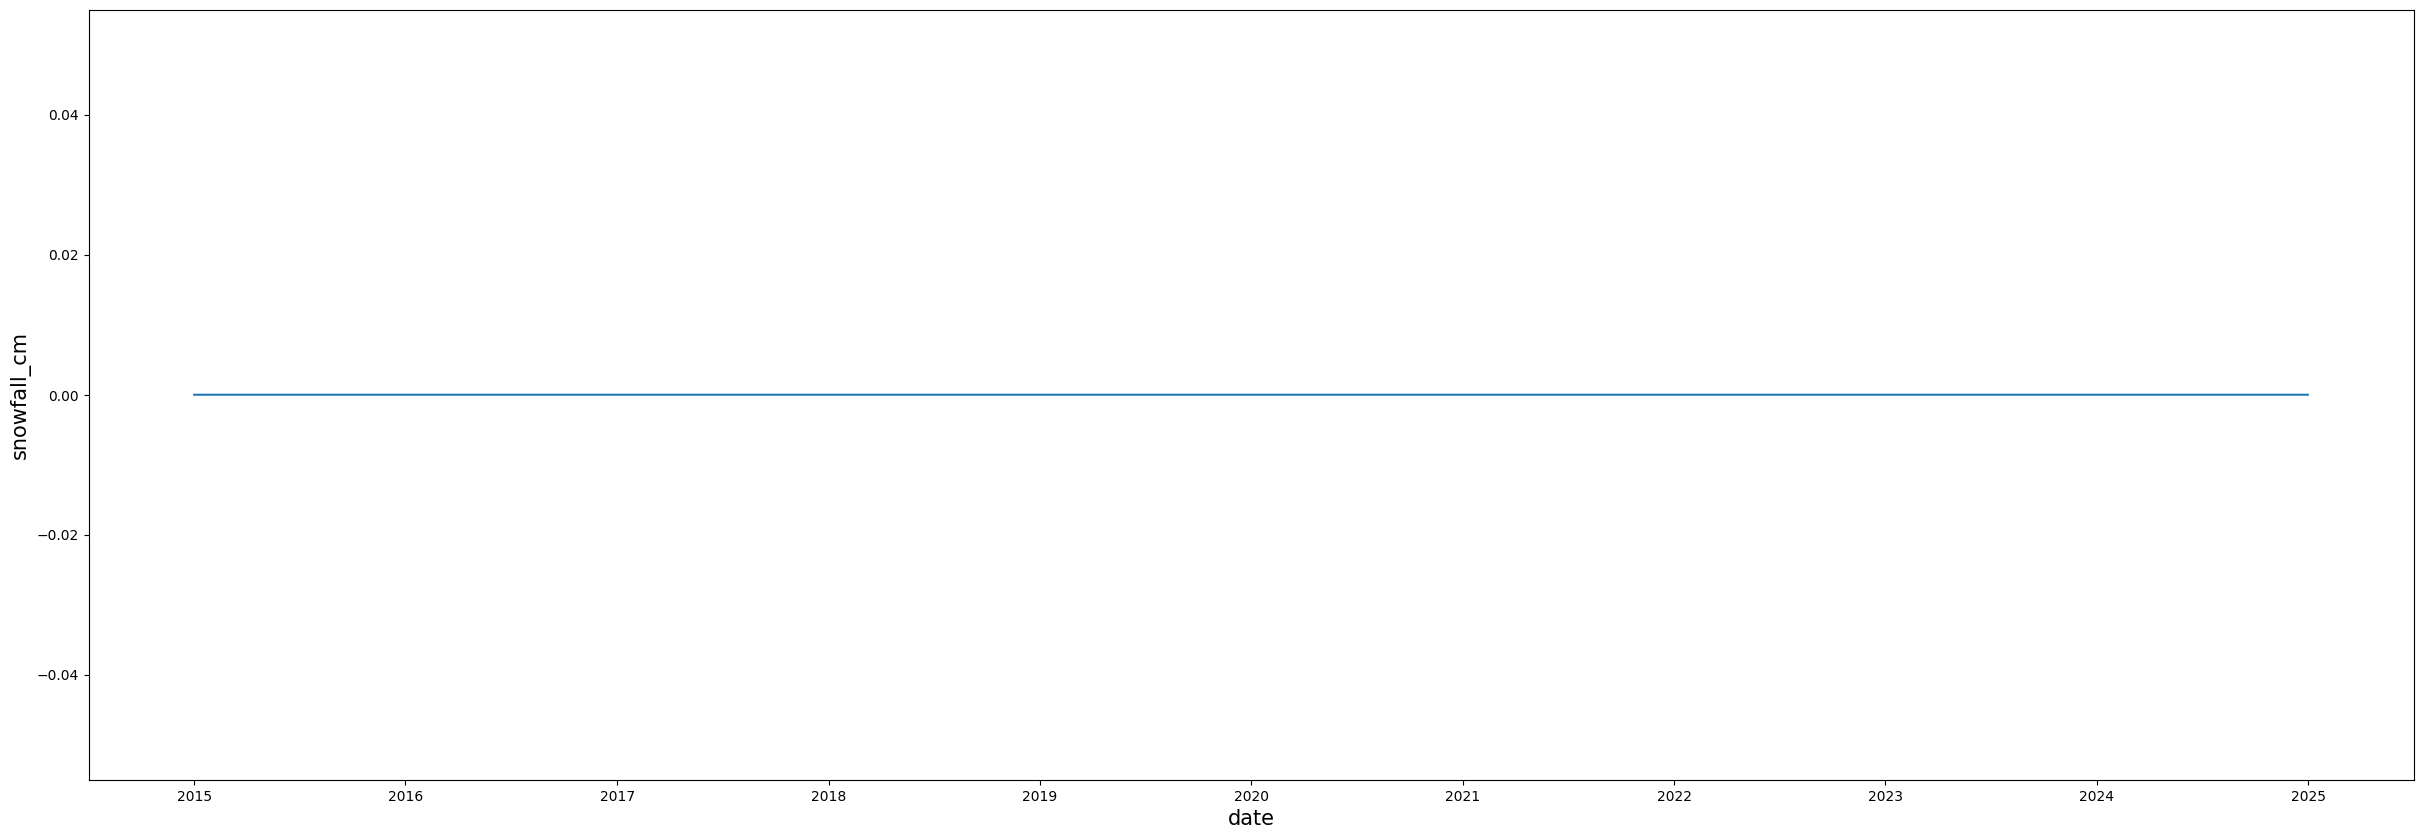

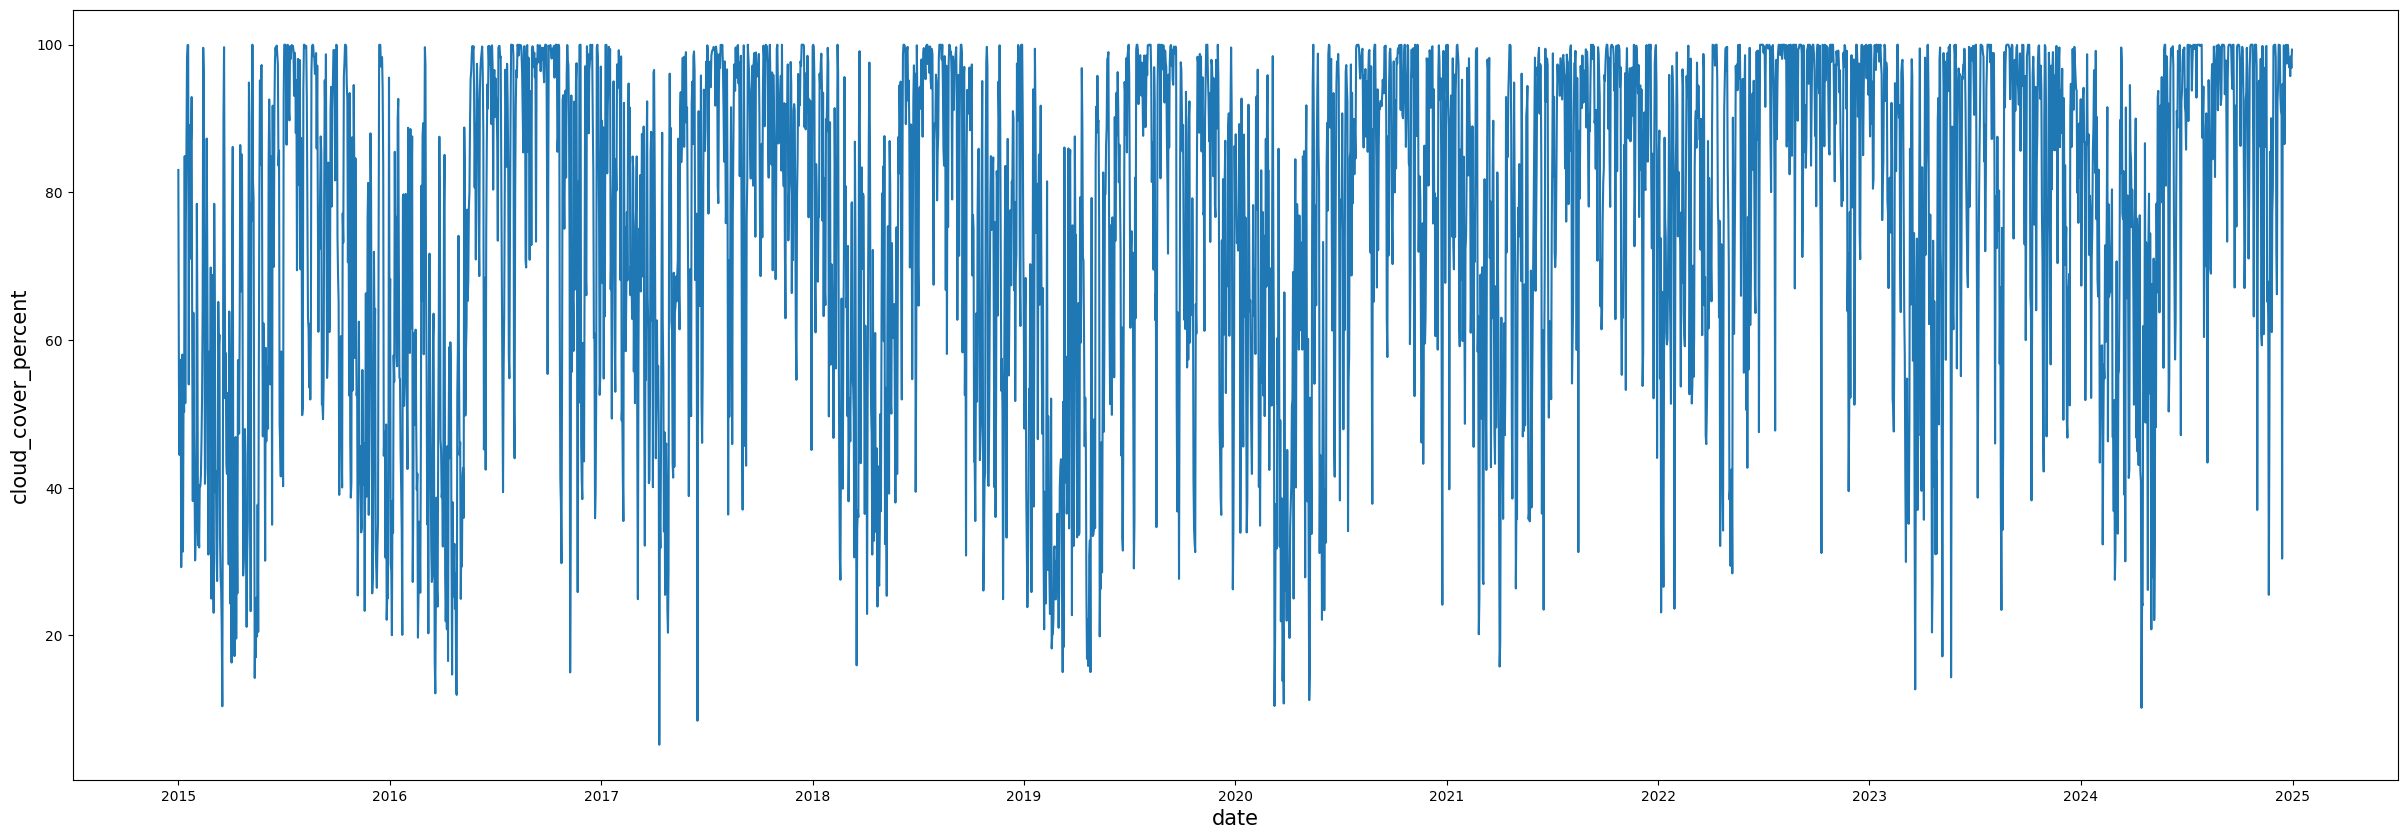

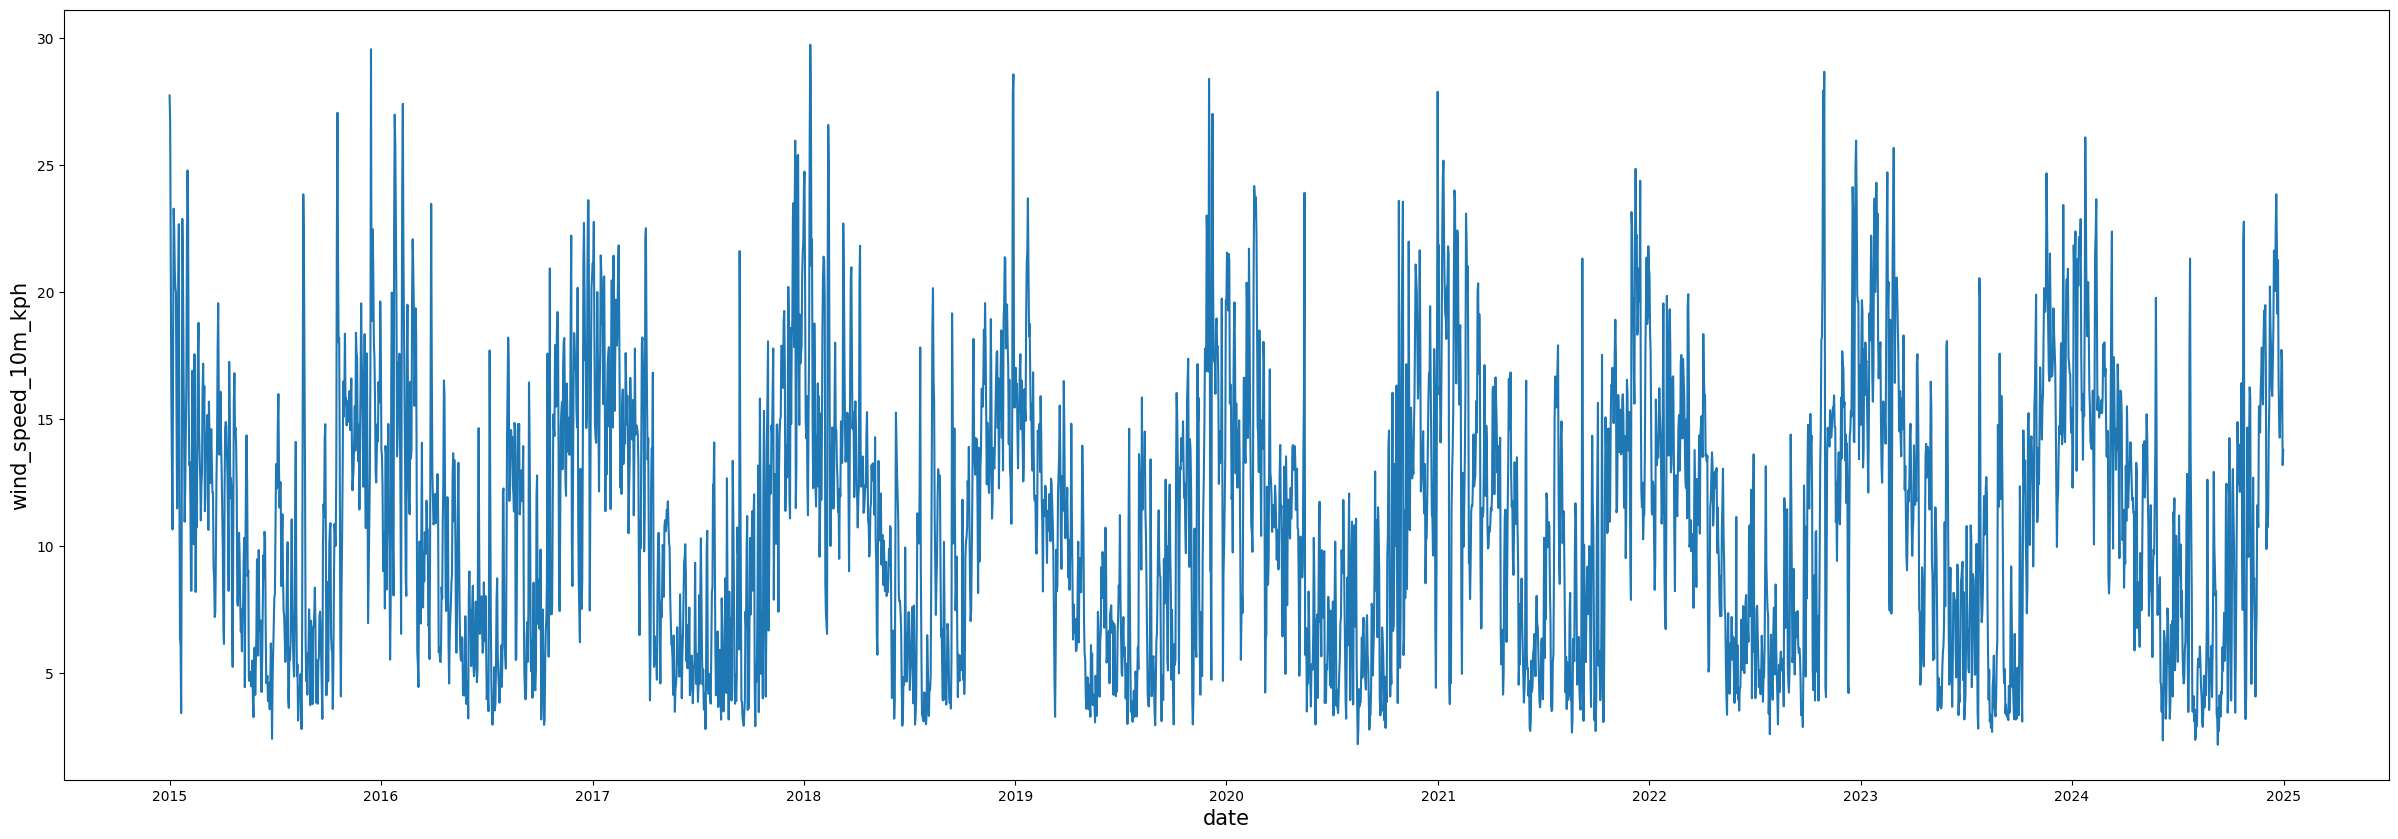

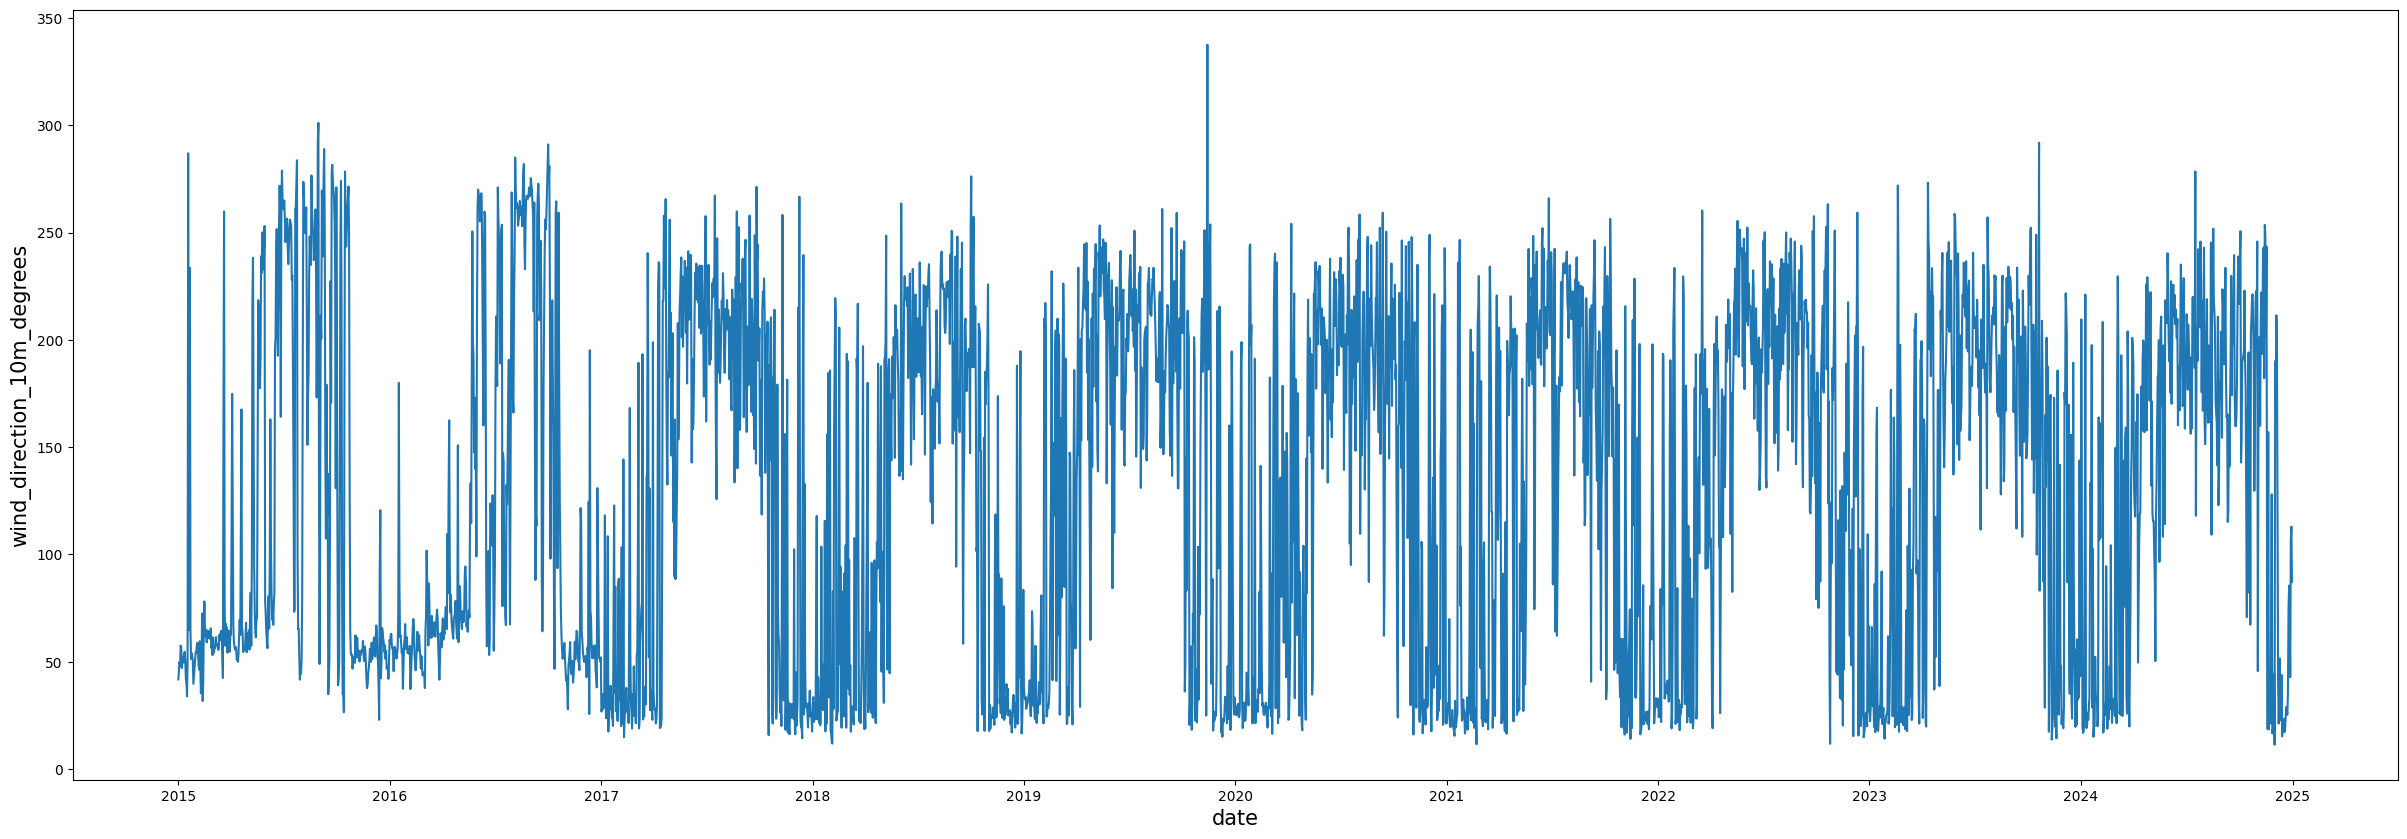

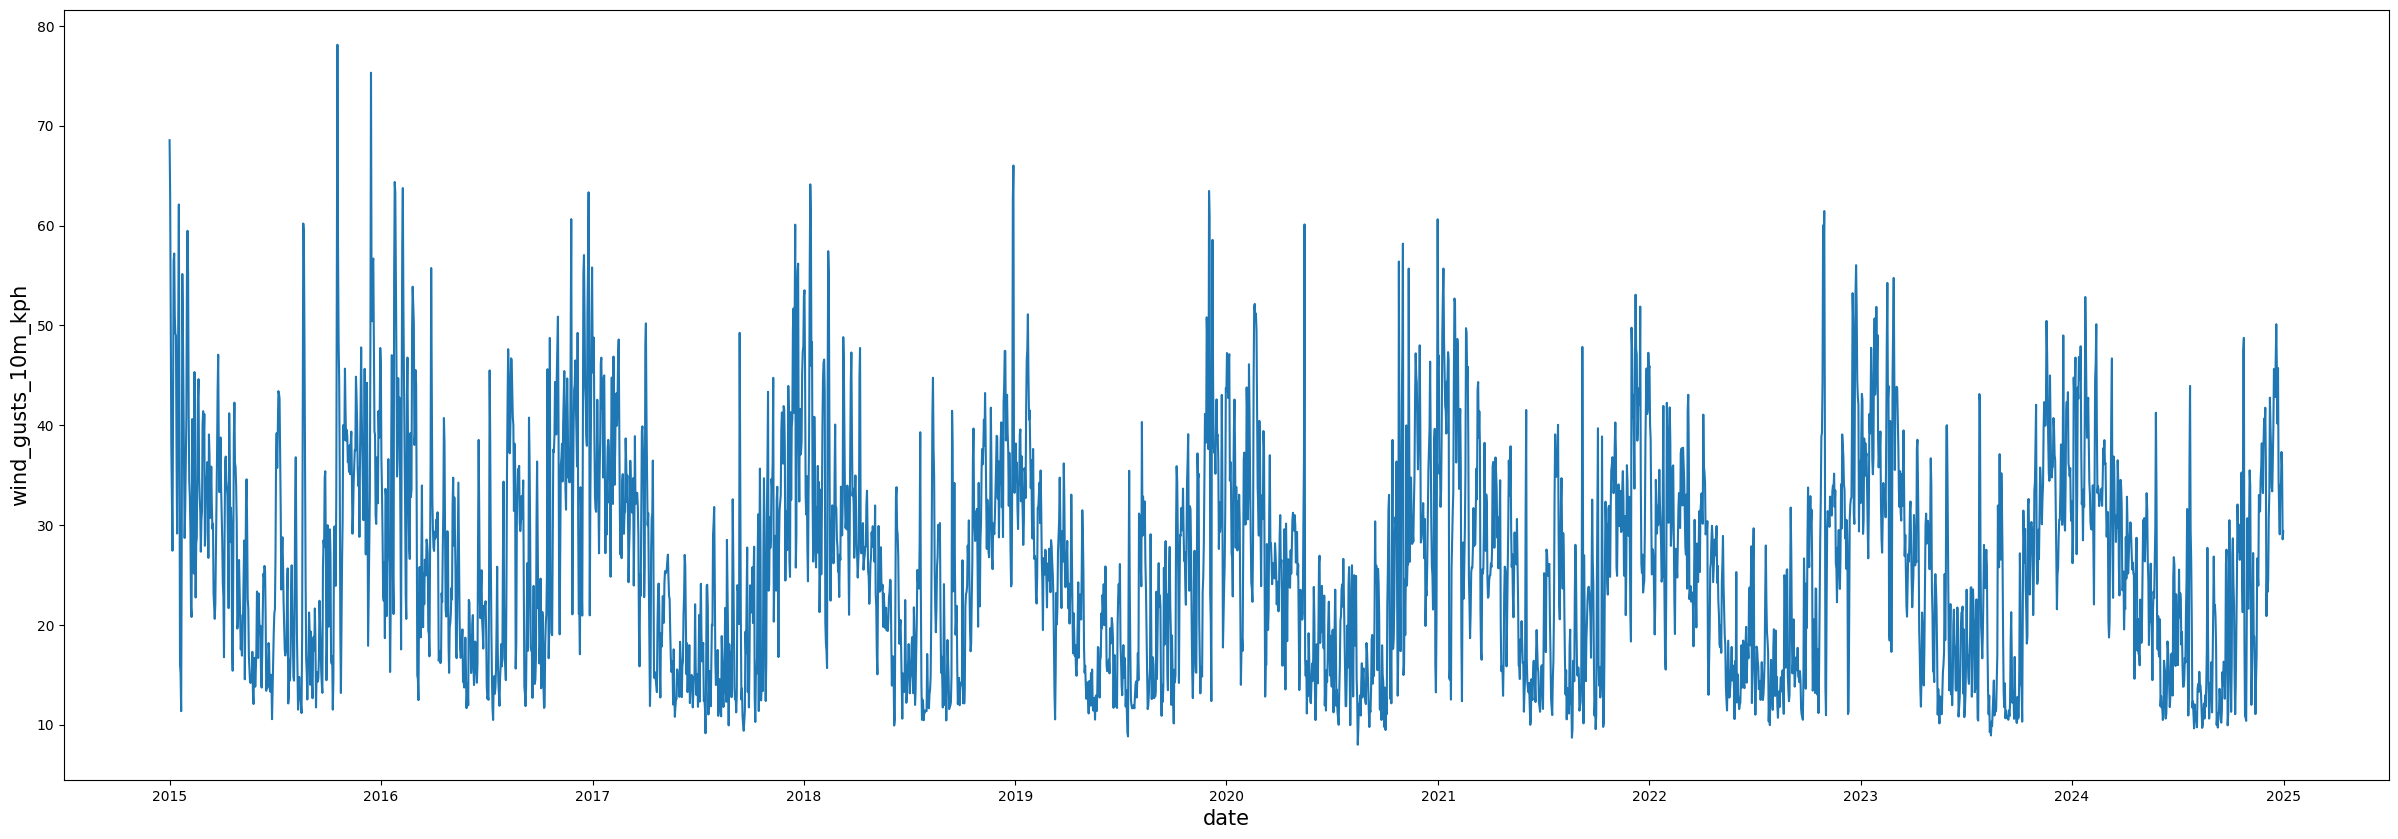

In [51]:
sample_daily = weather_data.resample("1D").mean()
visualize(sample_daily)

#### Notes

- Ask to identify location of the data
- Ask if its better to use daily or hourly data. Explain in what case its better.

In [94]:
def filter_data_on_date(data, start: pd.Timestamp, end: pd.Timestamp) -> pd.DataFrame:

    return data.loc[start:end]


FEATURES = ["rain_mm", "relative_humidity_2m_percent", "dew_point_2m_c", "cloud_cover_percent", "wind_speed_10m_kph", "wind_gusts_10m_kph"]
TARGET = "temperature_2m_c"

training_data = filter_data_on_date(
    data=weather_data,
    start=datetime.datetime(2015, 1, 1),
    end=datetime.datetime(2015, 1, 31)
)

test_data = filter_data_on_date(
    data=weather_data,
    start=datetime.datetime(2015, 2, 1),
    end=datetime.datetime(2015, 2, 28)
)

In [95]:
# Make it a forcasting problem
training_data.loc[:,[TARGET]] = training_data[TARGET].shift(-1)
training_data = training_data.dropna()
test_data.loc[:,[TARGET]] = test_data[TARGET].shift(-1)
test_data = test_data.dropna()

In [96]:
# Separate our x and y
x_train, y_train = training_data[FEATURES], training_data[TARGET]
x_test, y_test = test_data[FEATURES], test_data[TARGET]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [97]:
# Create matrix optimized for xgboost
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Define parameters for model
params = {
    "objective": "reg:squarederror", # regression,
    "eval_metric": "rmse",
    "learning_rate": 0.01,
    "max_depth": 11
}

model = xgb.train(params, dtrain, num_boost_round=100)

In [98]:
# Doing the prediction
y_pred = model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.3f}")

# Then add r2

r2 = r2_score(y_test, y_pred)
print(f"R2: {r2:.3f}")

RMSE: 1.281
R2: 0.047


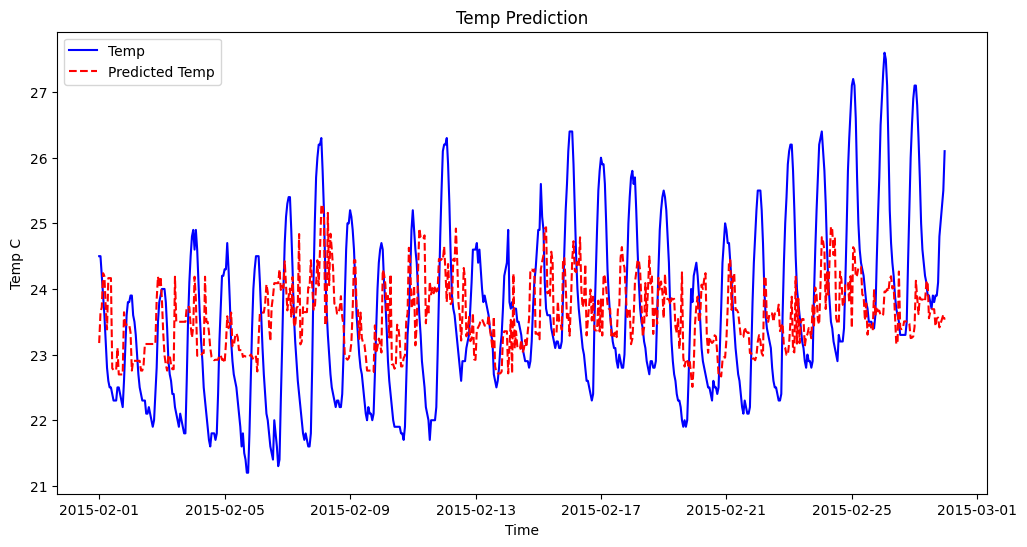

In [99]:
def show_scores(ytest, ypred):
    plt.figure(figsize=(12, 6))
    plt.plot(ytest.index, ytest, label="Temp", color="blue")
    plt.plot(ytest.index, ypred, label="Predicted Temp", color="red", linestyle="dashed")
    plt.xlabel("Time")
    plt.ylabel("Temp C")
    plt.legend()
    plt.title("Temp Prediction")
    plt.show()

show_scores(y_test, y_pred)

In [100]:
def get_monthly_dates(start_year: int, start_month: int, years: int = 20):
    start_date = datetime.datetime(start_year, start_month, 1)
    end_date = start_date + datetime.timedelta(days=years * 365)  # Approximate end date
    date_range = pd.date_range(start=start_date, end=end_date, freq="MS")  # Month start dates

    result = []
    for date in date_range:
        start_of_month = date
        next_month = date + pd.DateOffset(months=1)
        end_of_month = next_month - datetime.timedelta(days=1)  # Last day of the month
        result.append((start_of_month, end_of_month))

    return result

In [104]:
def get_scoring(source_data, target_model, dates: list):
    scoring = []
    for start, end in dates:
        _test_data = filter_data_on_date(
            data=source_data,
            start=start,
            end=end
        )
    
        _test_data.loc[:,[TARGET]] = _test_data[TARGET].shift(-1)
        _test_data = _test_data.dropna()
        _x_test, _y_test = _test_data[FEATURES], _test_data[TARGET]
        _x_test = scaler.transform(_x_test)
    
        _dtest = xgb.DMatrix(_x_test, label=_y_test)
    
        _y_pred = target_model.predict(_dtest)
        _rmse = np.sqrt(mean_squared_error(_y_test, _y_pred))
        _r2_score = r2_score(_y_test, _y_pred)
    
        scoring.append({"date": start, "mse": _rmse, "r2": _r2_score})

    return pd.DataFrame(scoring)

# Start with feb to feb first, then go next year up to 4 years, then up to all dataset
# to_test_dates = get_monthly_dates(2015, 2, 1)
# 4 years
# to_test_dates = get_monthly_dates(2016, 1, 4)
# 8 years
to_test_dates = get_monthly_dates(2016, 1, 8)
scores_df = get_scoring(weather_data, model, to_test_dates)

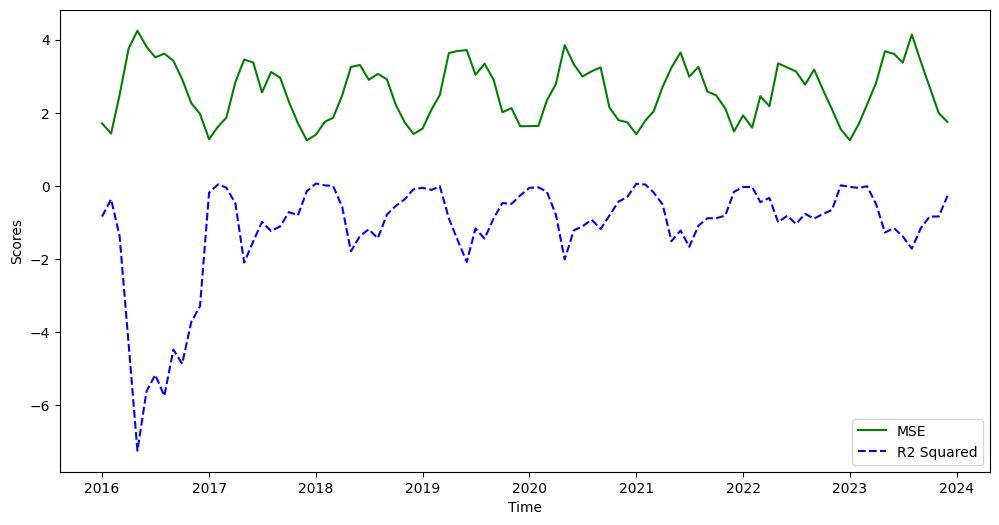

In [105]:
plt.figure(figsize=(12, 6))
plt.plot(scores_df.date, scores_df.mse, label="MSE", color="green")
plt.plot(scores_df.date, scores_df.r2, label="R2 Squared", color="blue", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Scores")
plt.legend()
plt.show()

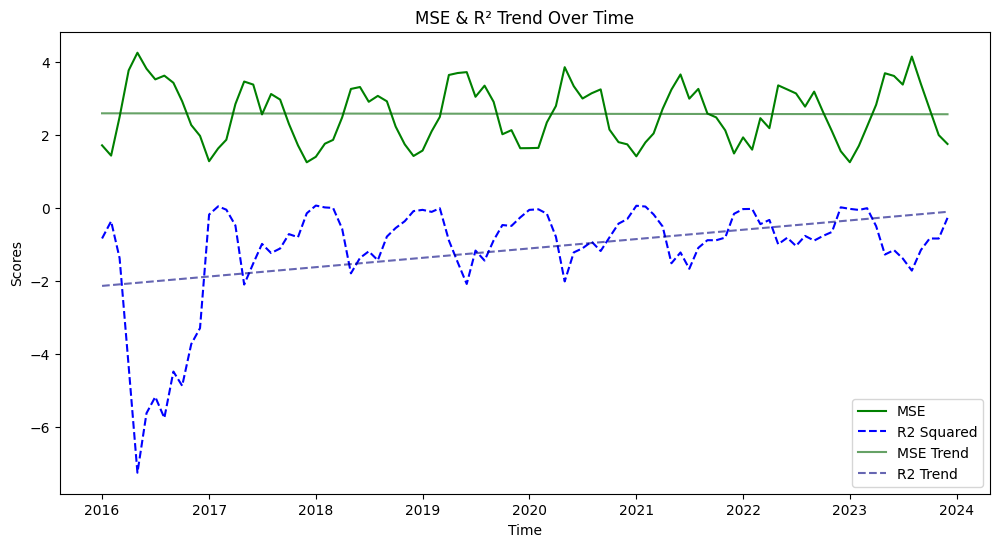

In [106]:
def show_performance_trend(scoring_df):
    scoring_df["date_ordinal"] = scoring_df["date"].apply(lambda x: x.toordinal())

    # Fit a linear trend line for MSE
    mse_trend = np.poly1d(np.polyfit(scoring_df["date_ordinal"], scoring_df["mse"], 1))
    
    # Fit a linear trend line for R²
    r2_trend = np.poly1d(np.polyfit(scoring_df["date_ordinal"], scoring_df["r2"], 1))
    
    # Generate trend values
    trend_dates = scoring_df["date_ordinal"]
    mse_trend_values = mse_trend(trend_dates)
    r2_trend_values = r2_trend(trend_dates)
    
    # Plot the actual values
    plt.figure(figsize=(12, 6))
    plt.plot(scoring_df.date, scoring_df.mse, label="MSE", color="green")
    plt.plot(scoring_df.date, scoring_df.r2, label="R2 Squared", color="blue", linestyle="dashed")
    
    # Plot trend lines
    plt.plot(scoring_df.date, mse_trend_values, color="darkgreen", linestyle="solid", alpha=0.6, label="MSE Trend")
    plt.plot(scoring_df.date, r2_trend_values, color="navy", linestyle="dashed", alpha=0.6, label="R2 Trend")
    
    # Labels and legend
    plt.xlabel("Time")
    plt.ylabel("Scores")
    plt.legend()
    plt.title("MSE & R² Trend Over Time")
    plt.show()

show_performance_trend(scores_df)

#### Notes
- Extend training dates to 1 year
- Run same code
- Change training date to 4 years

In [116]:
# 1 year
start_train = datetime.datetime(2015, 1, 1)
end_train = datetime.datetime(2015, 12, 31)
test_year = 2016

# 4 years
# start_train = datetime.datetime(2018, 1, 1)
# end_train = datetime.datetime(2018, 12, 31)
# test_year = 2019

# Use 1 years worth of training data
updated_training_data = filter_data_on_date(
    data=weather_data,
    start=start_train,
    end=end_train
)

updated_training_data.loc[:,[TARGET]] = updated_training_data[TARGET].shift(-1)
updated_training_data = updated_training_data.dropna()

_x_train, _y_train = updated_training_data[FEATURES], updated_training_data[TARGET]
_x_train = scaler.fit_transform(_x_train)
_dtrain = xgb.DMatrix(_x_train, label=_y_train)

yearly_model = xgb.train(params, _dtrain, num_boost_round=100)

In [117]:
to_test_dates = get_monthly_dates(test_year, 1, 4)
scores_df = get_scoring(weather_data, yearly_model, to_test_dates)

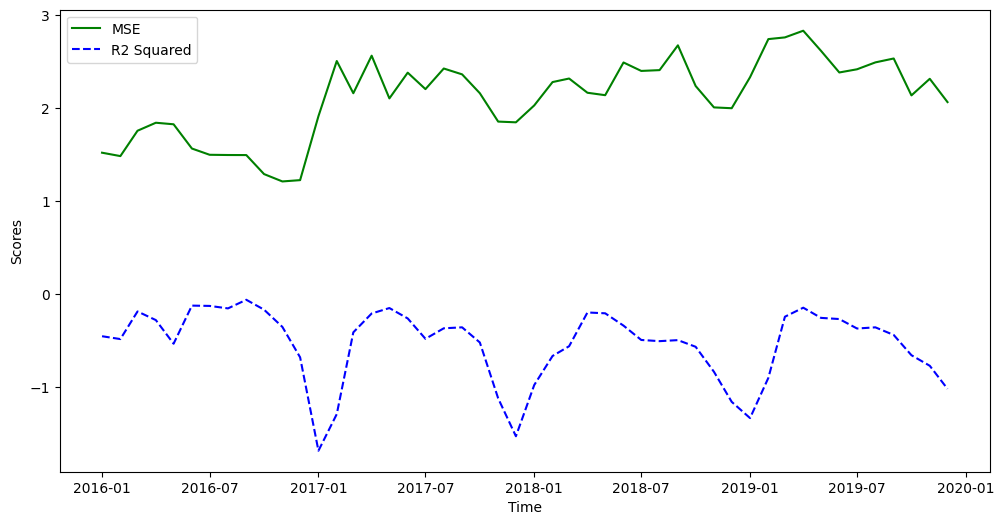

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(scores_df.date, scores_df.mse, label="MSE", color="green")
plt.plot(scores_df.date, scores_df.r2, label="R2 Squared", color="blue", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Scores")
plt.legend()
plt.show()

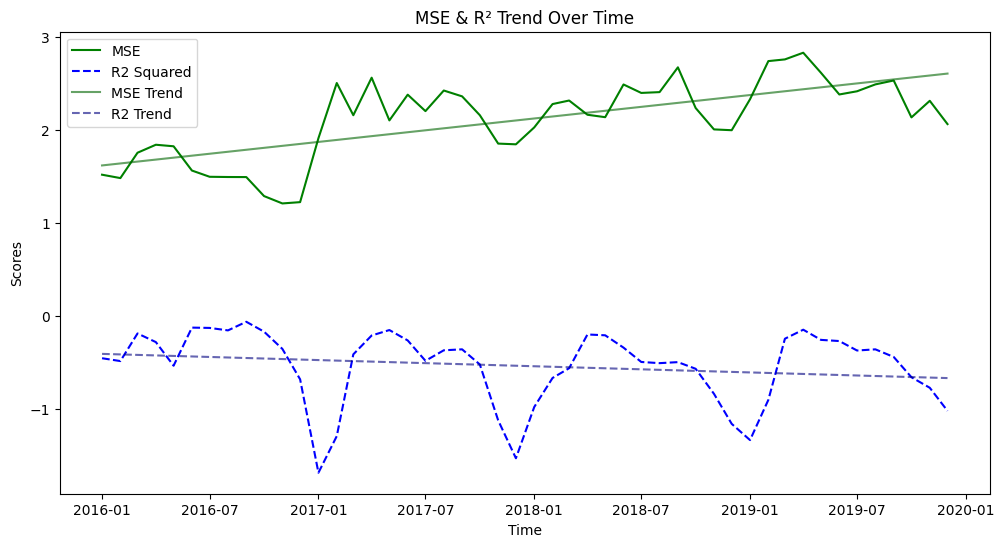

In [119]:
show_performance_trend(scores_df)

#### Notes
Check next dataset from southern hemisphere

In [120]:
raw_data_b = pd.read_csv(DATA_LOC_TEST)

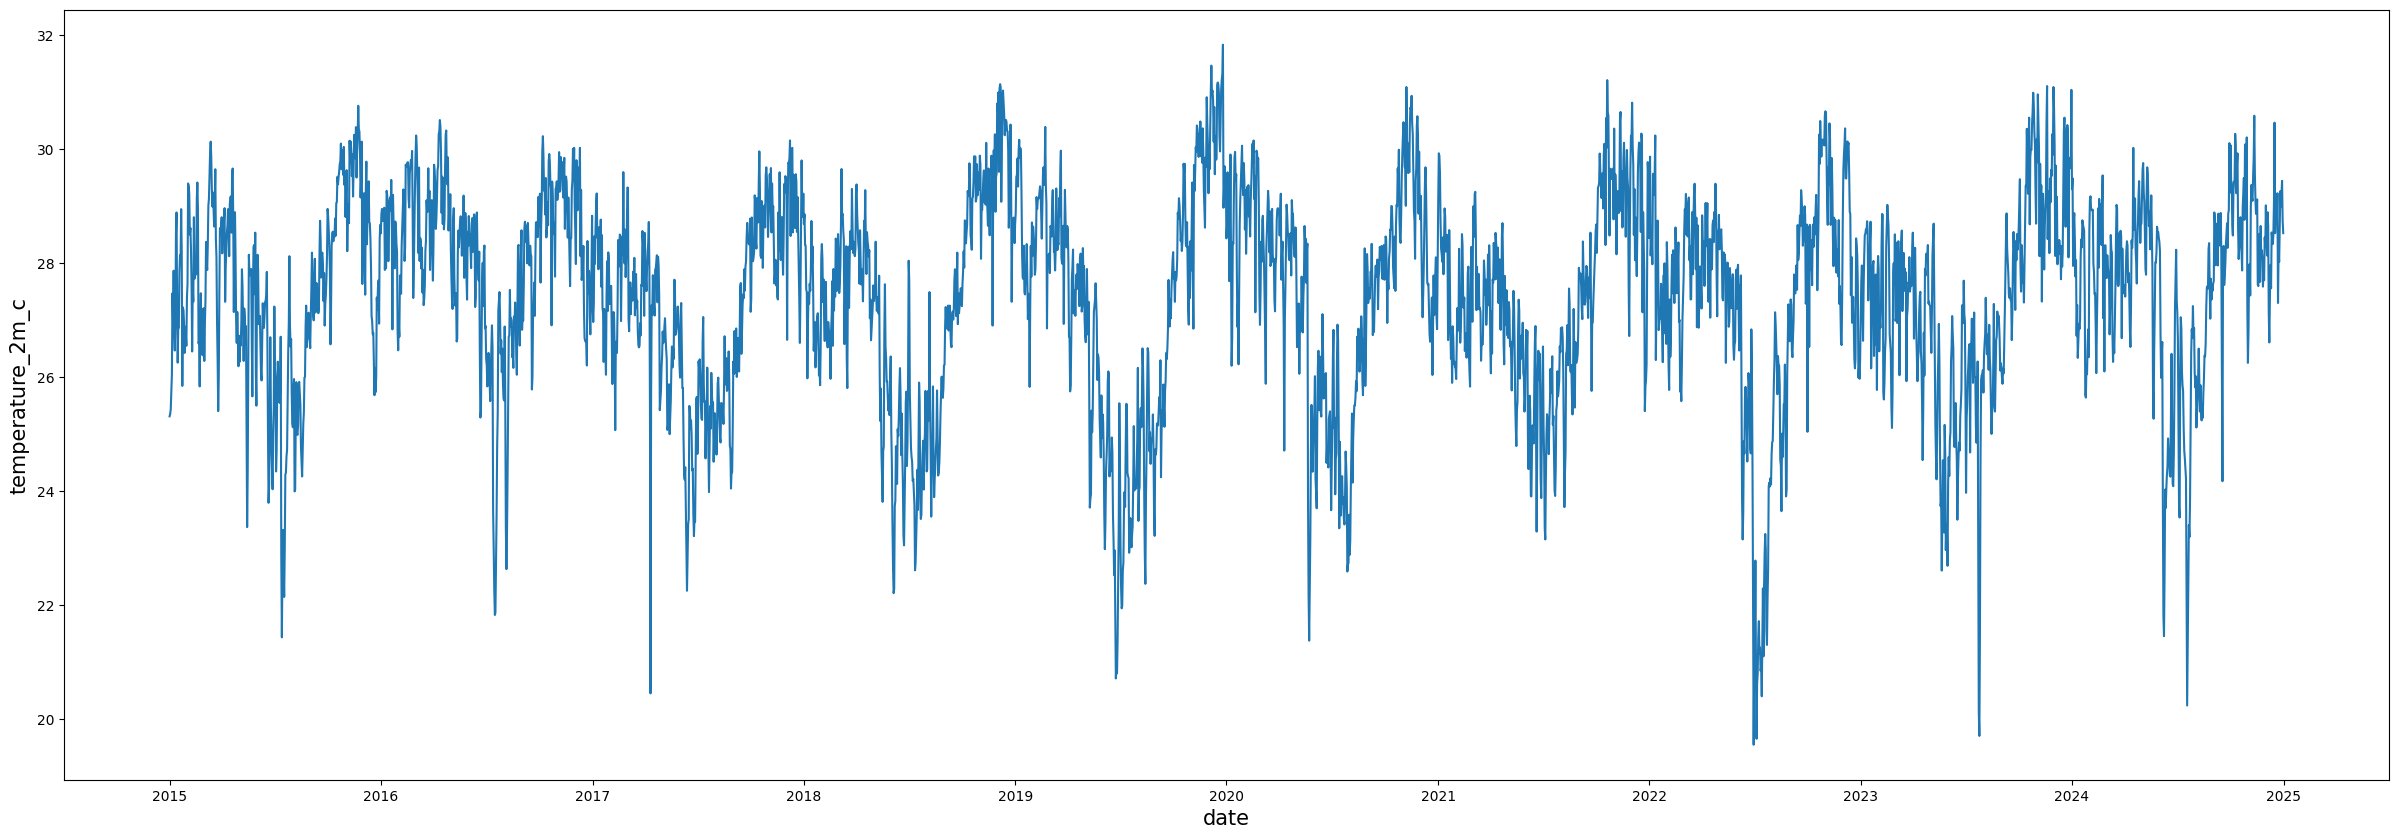

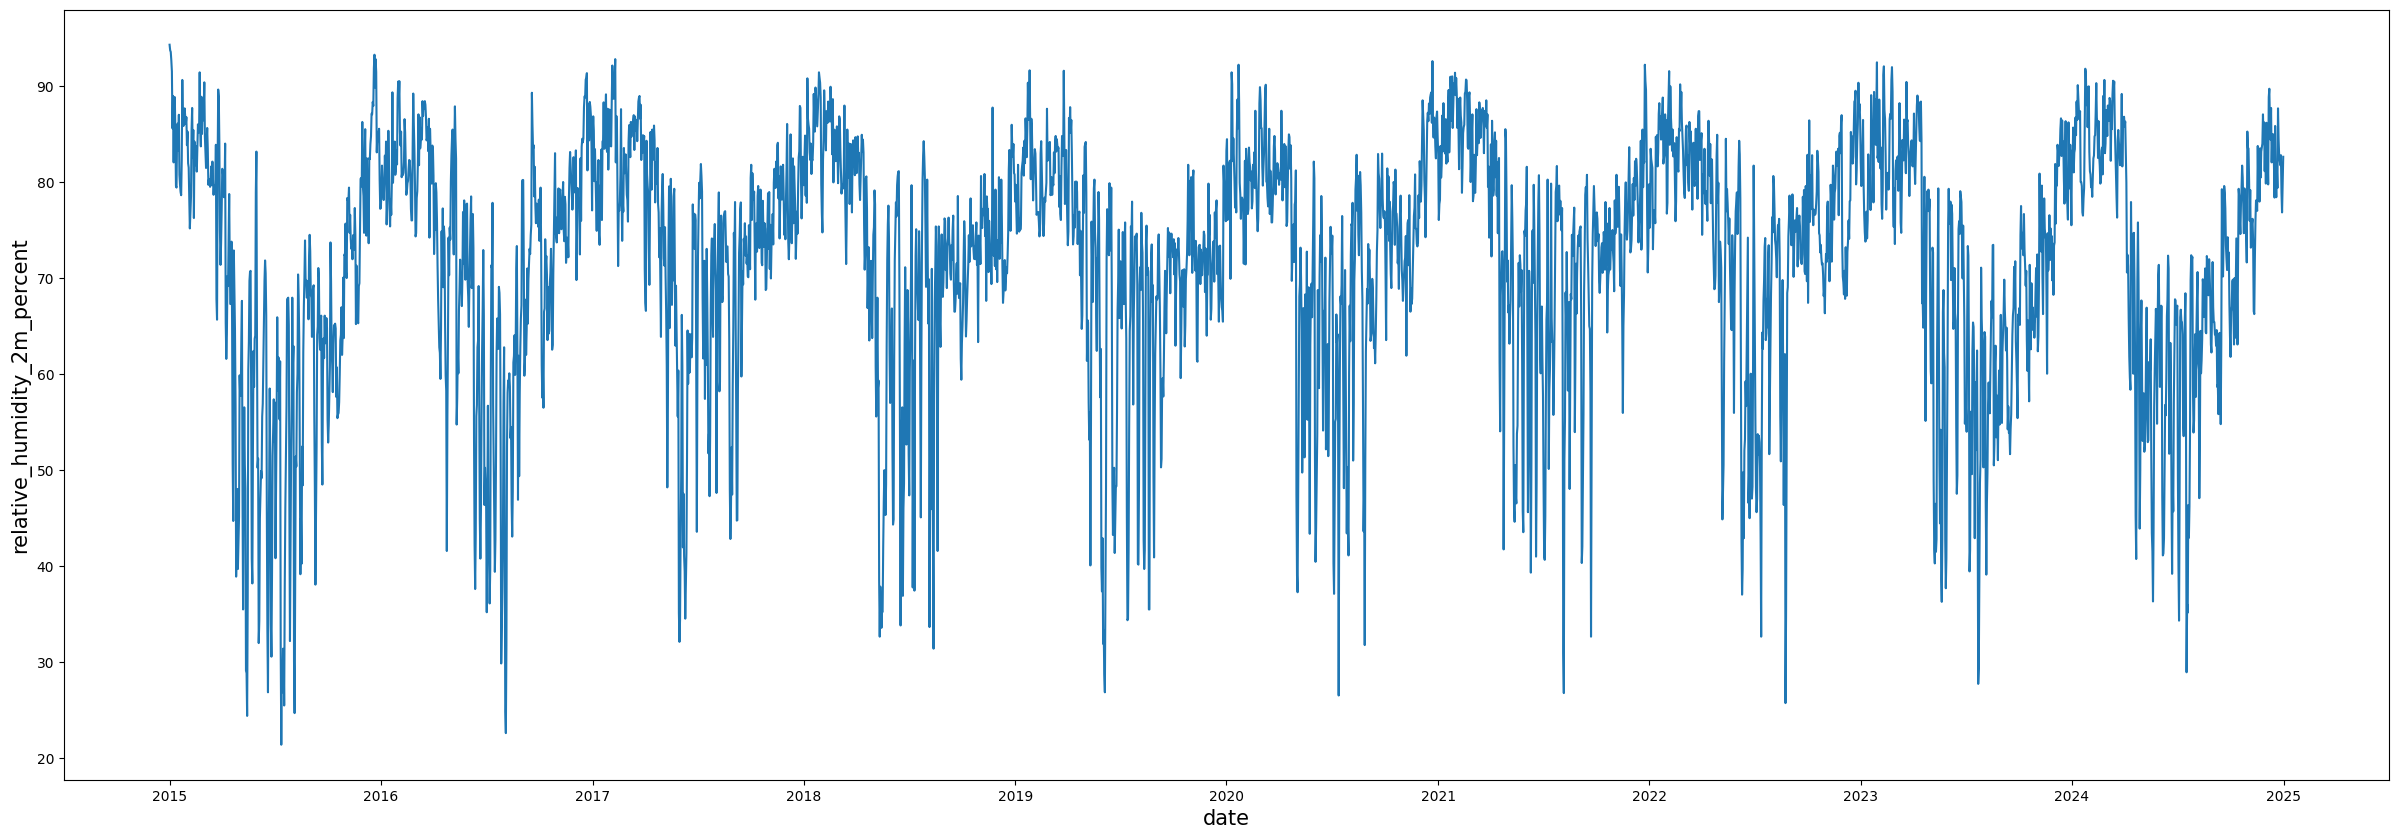

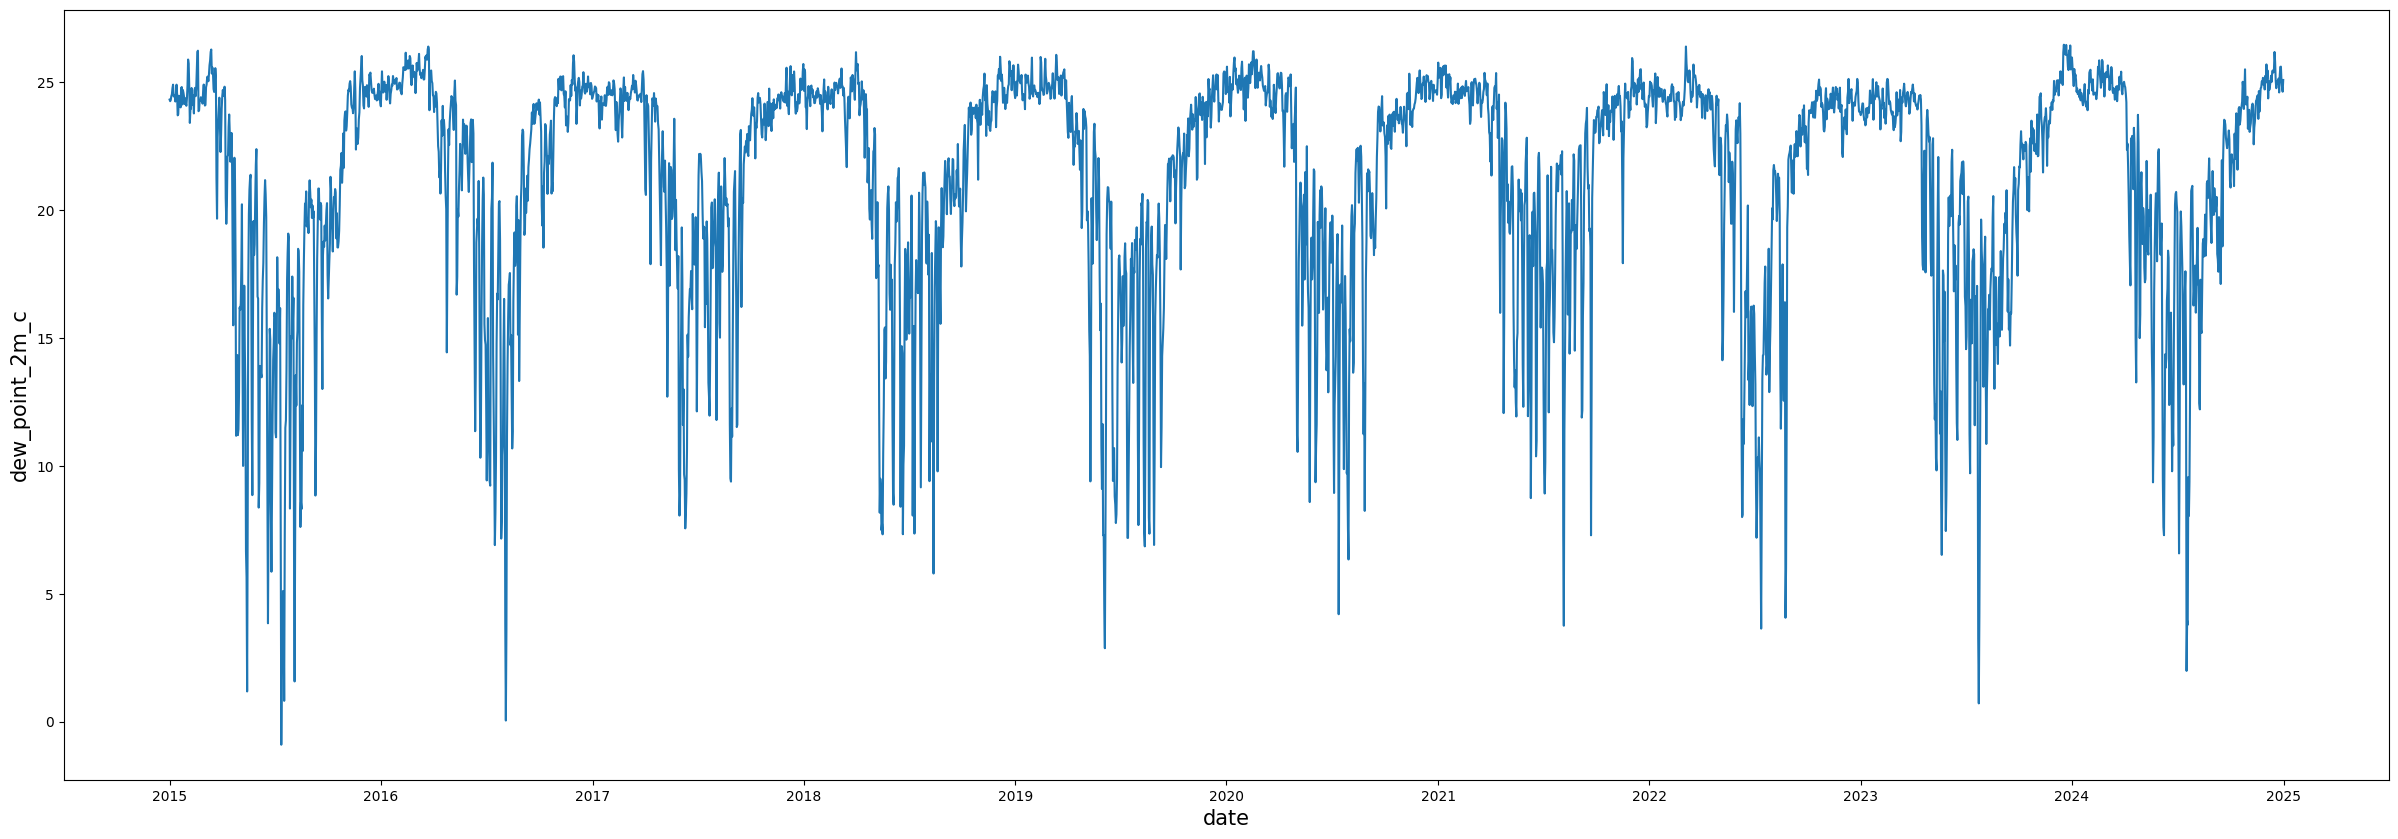

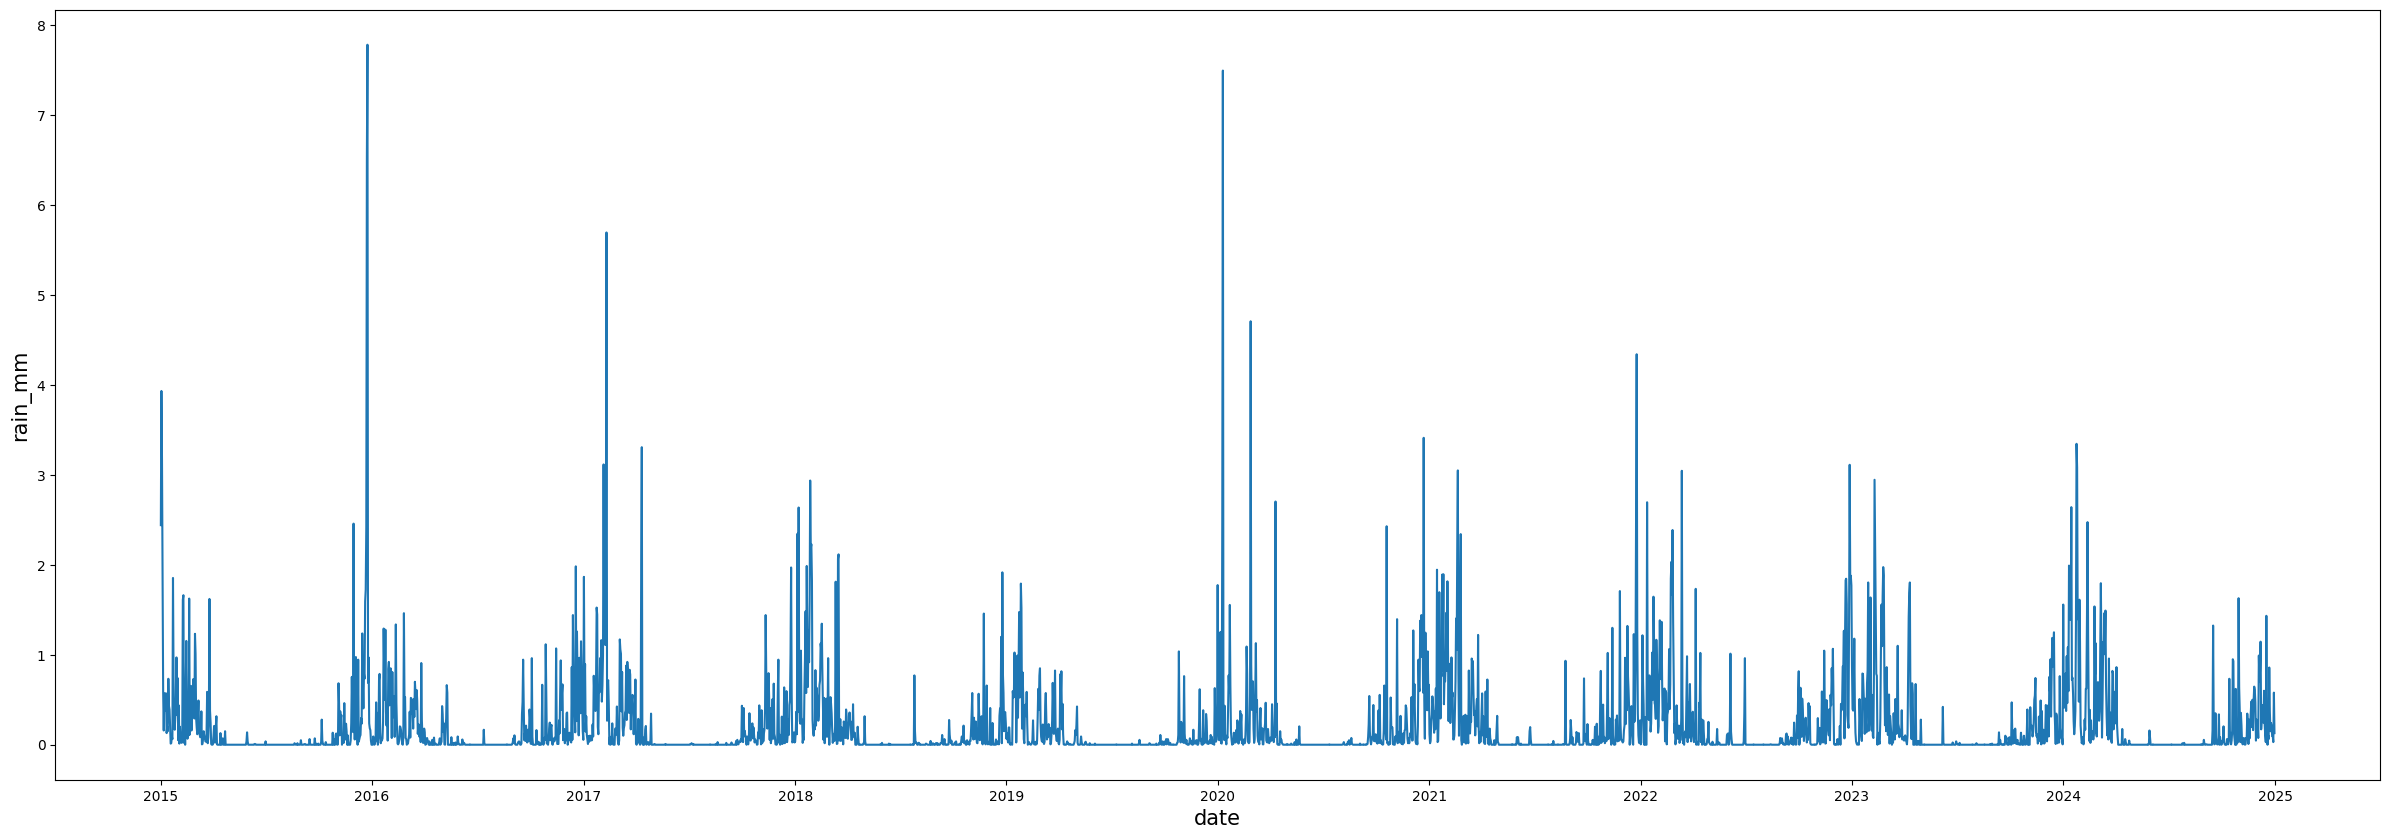

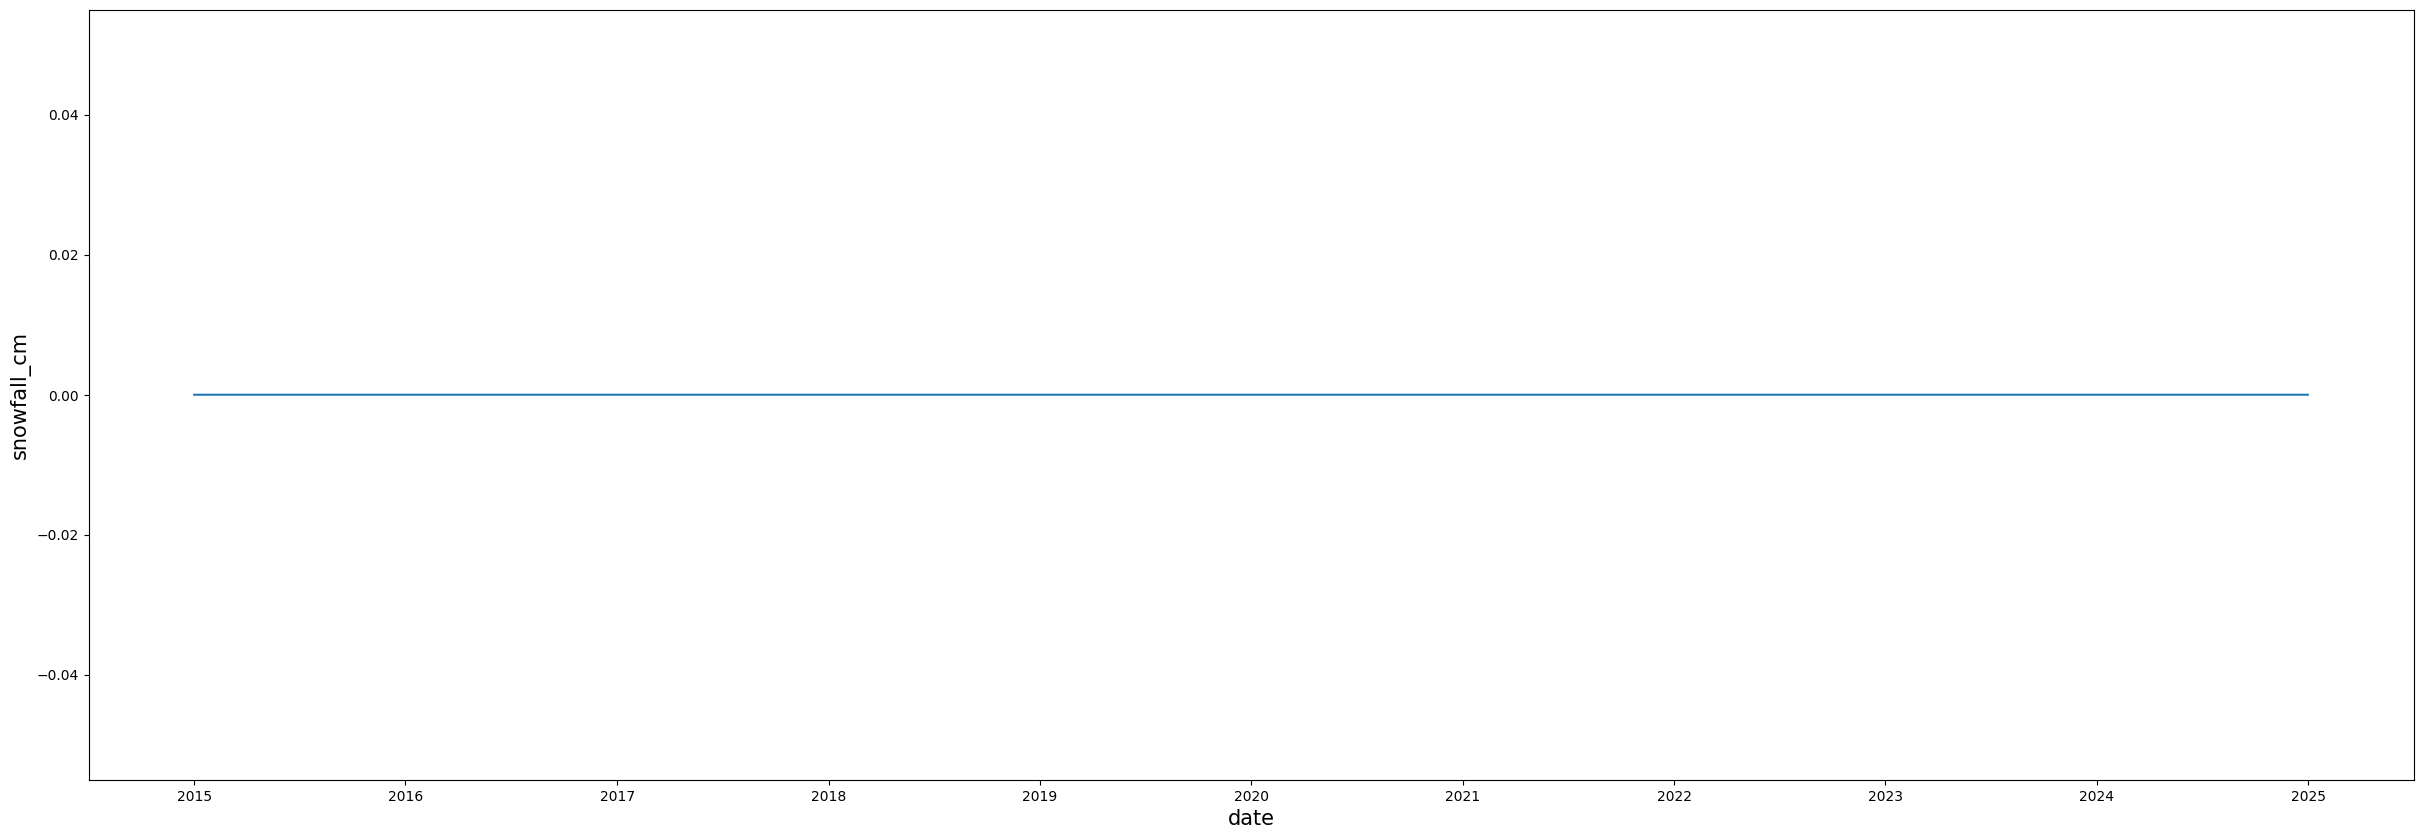

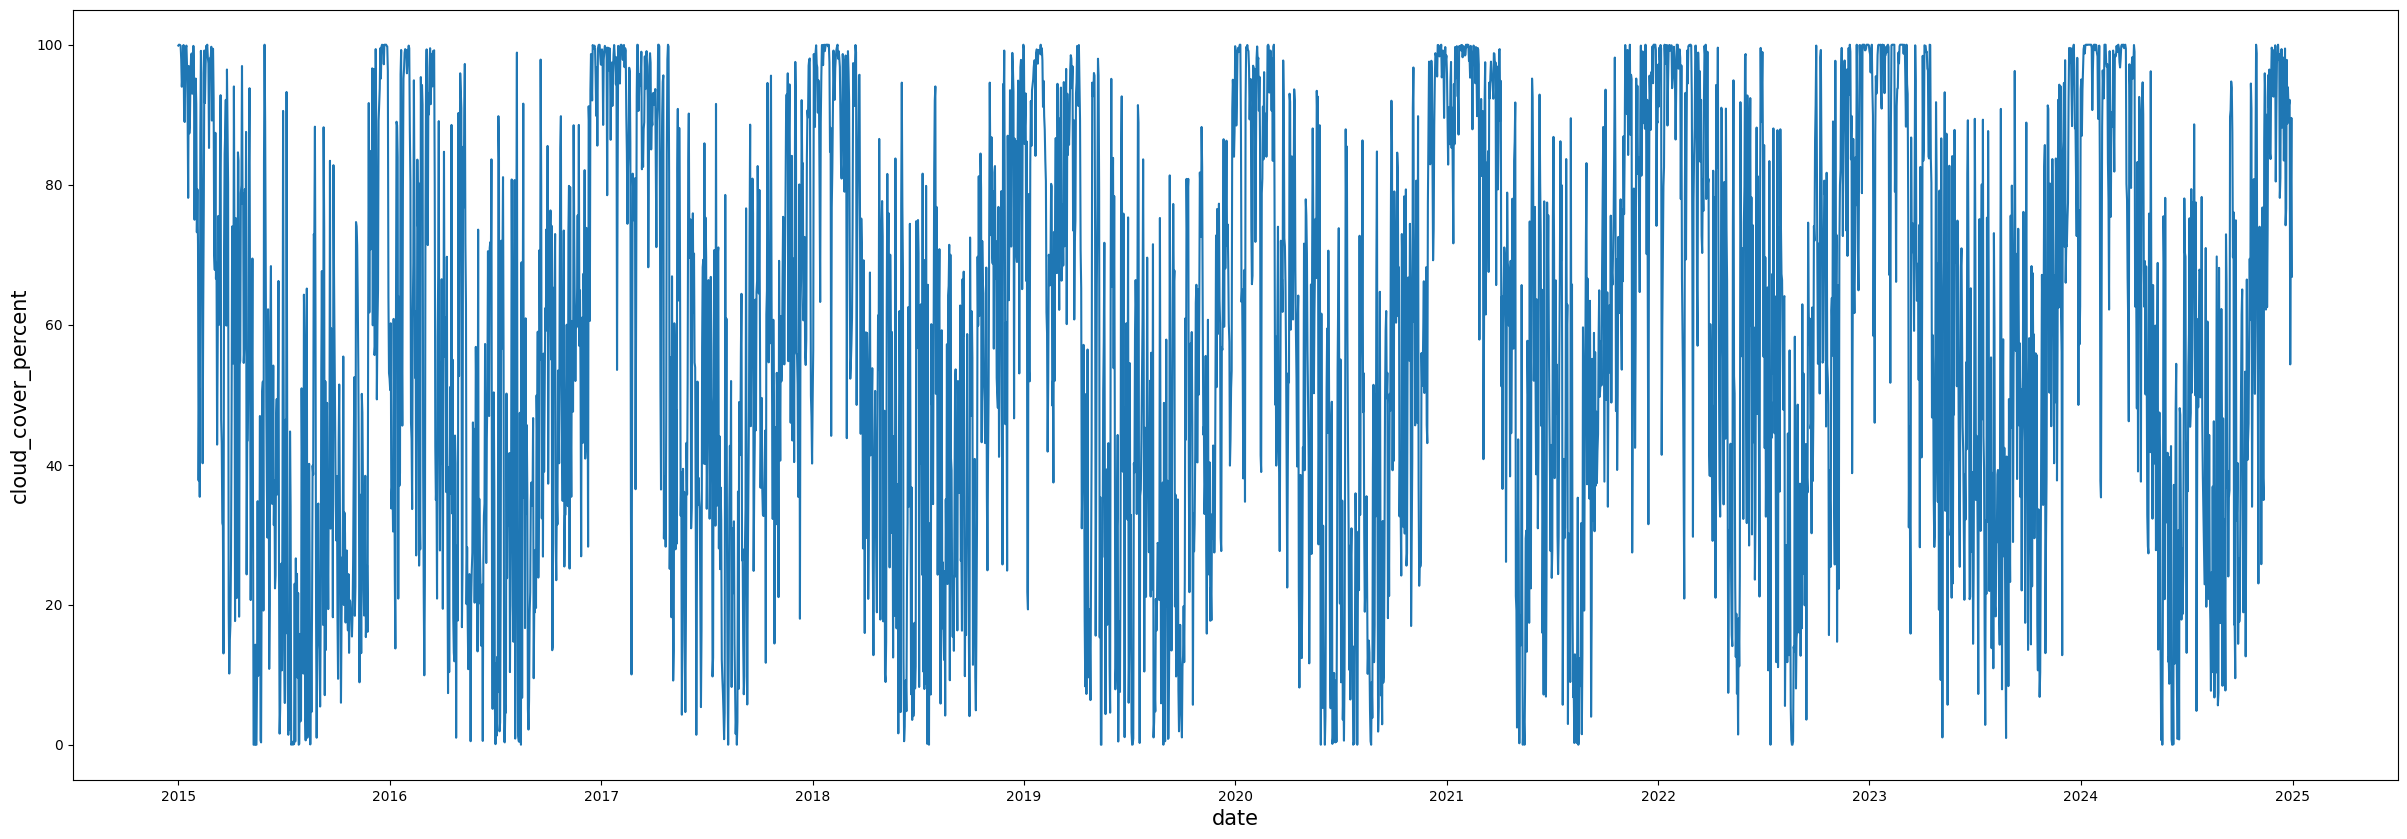

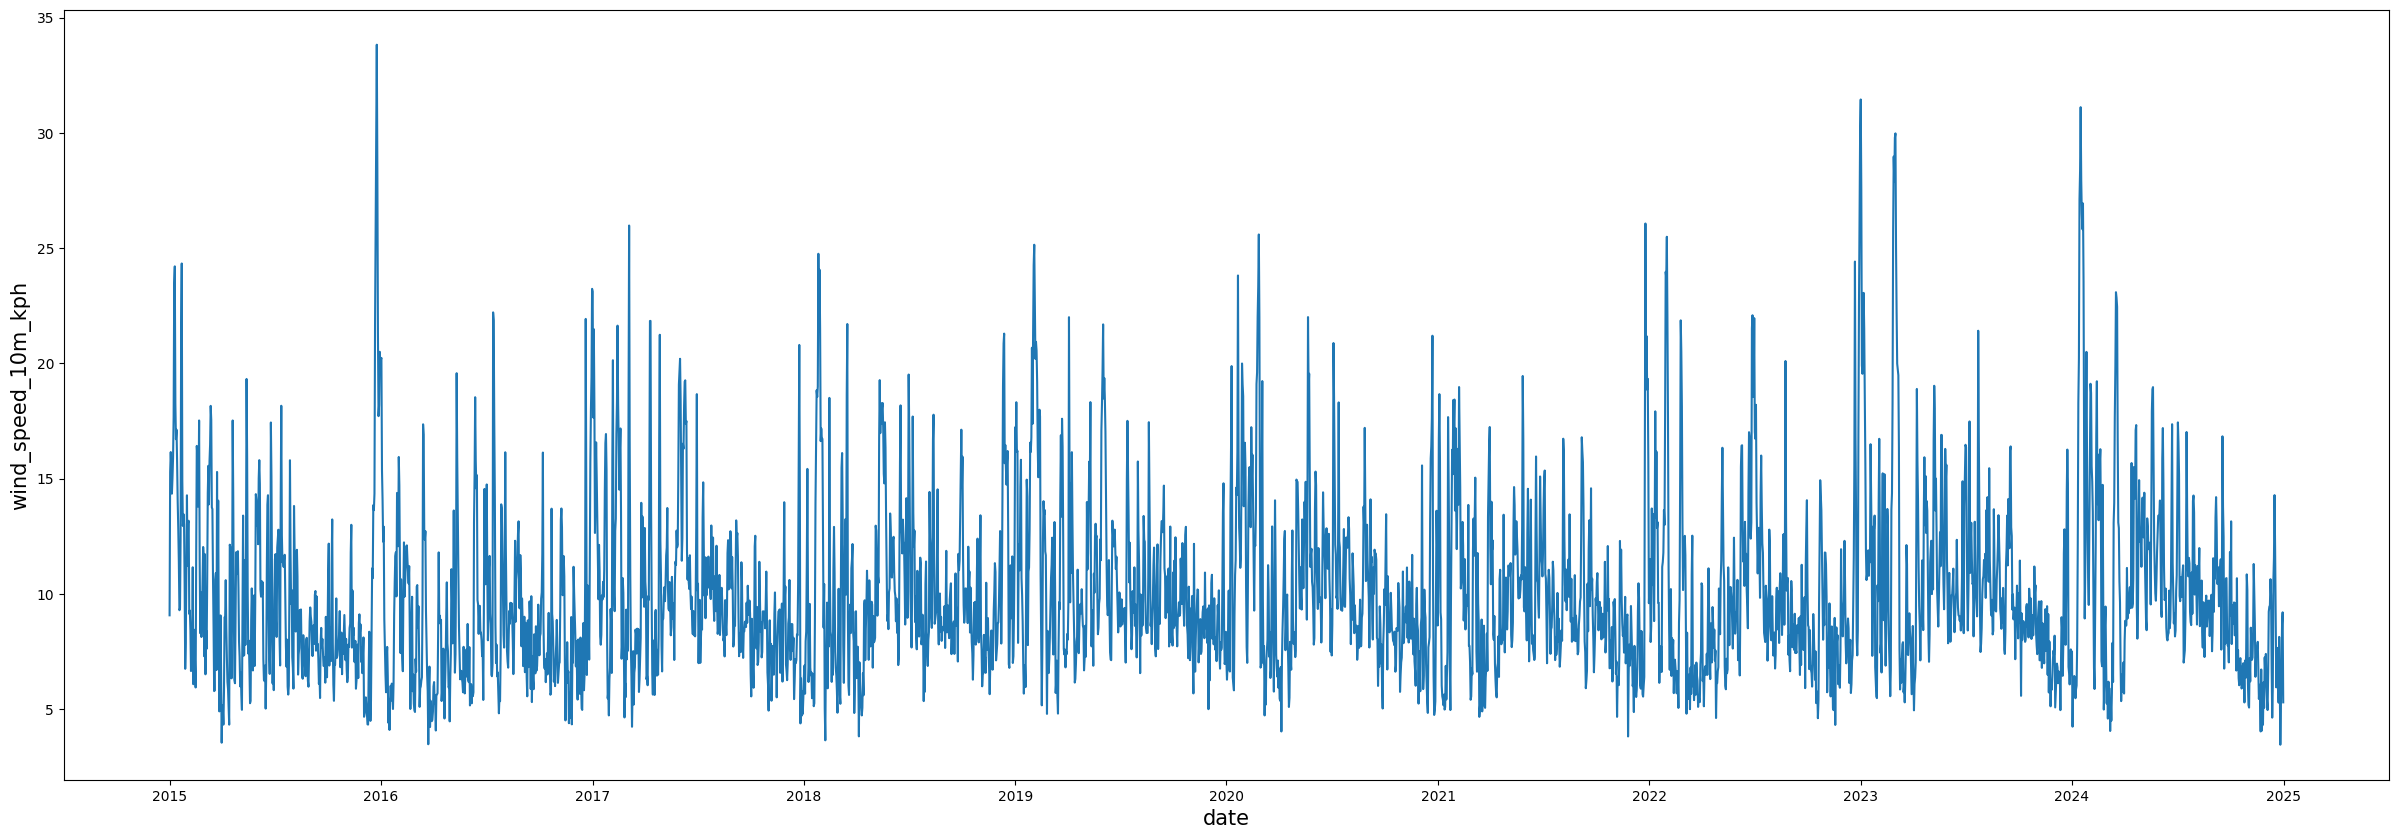

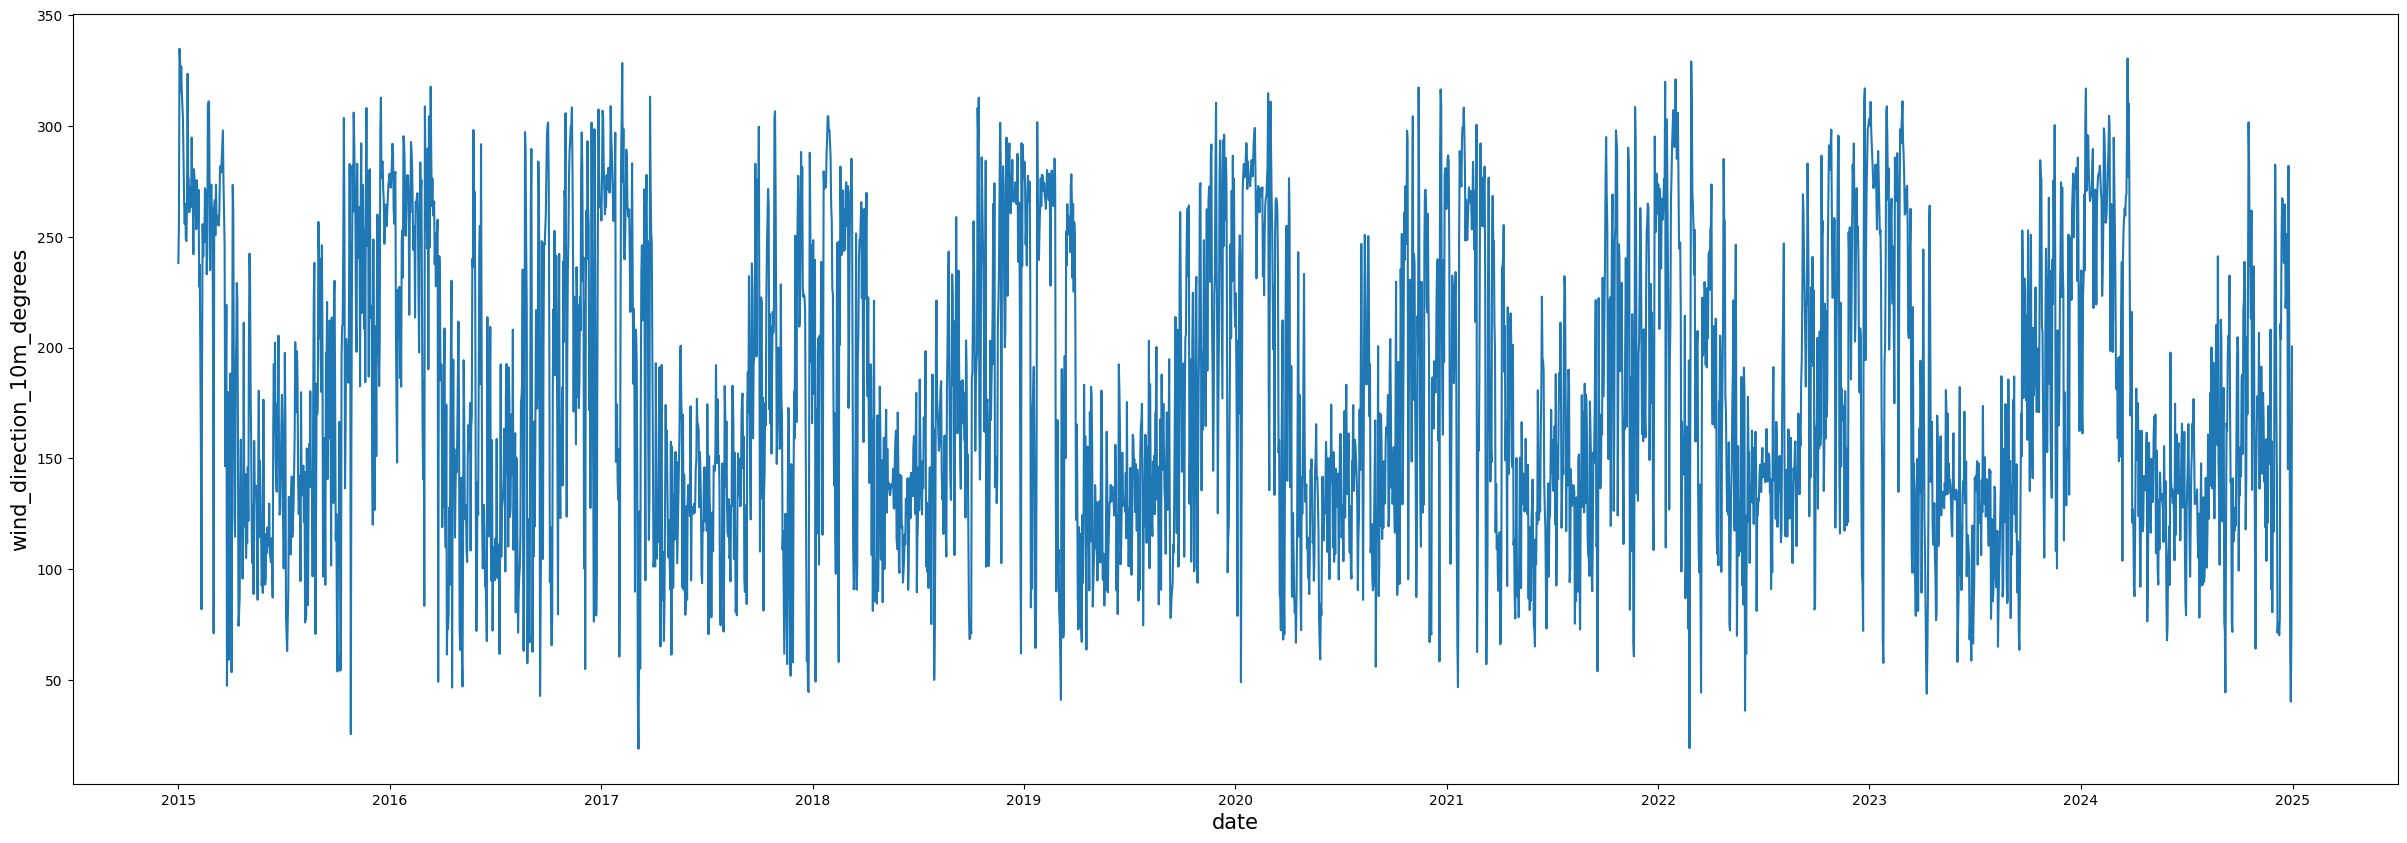

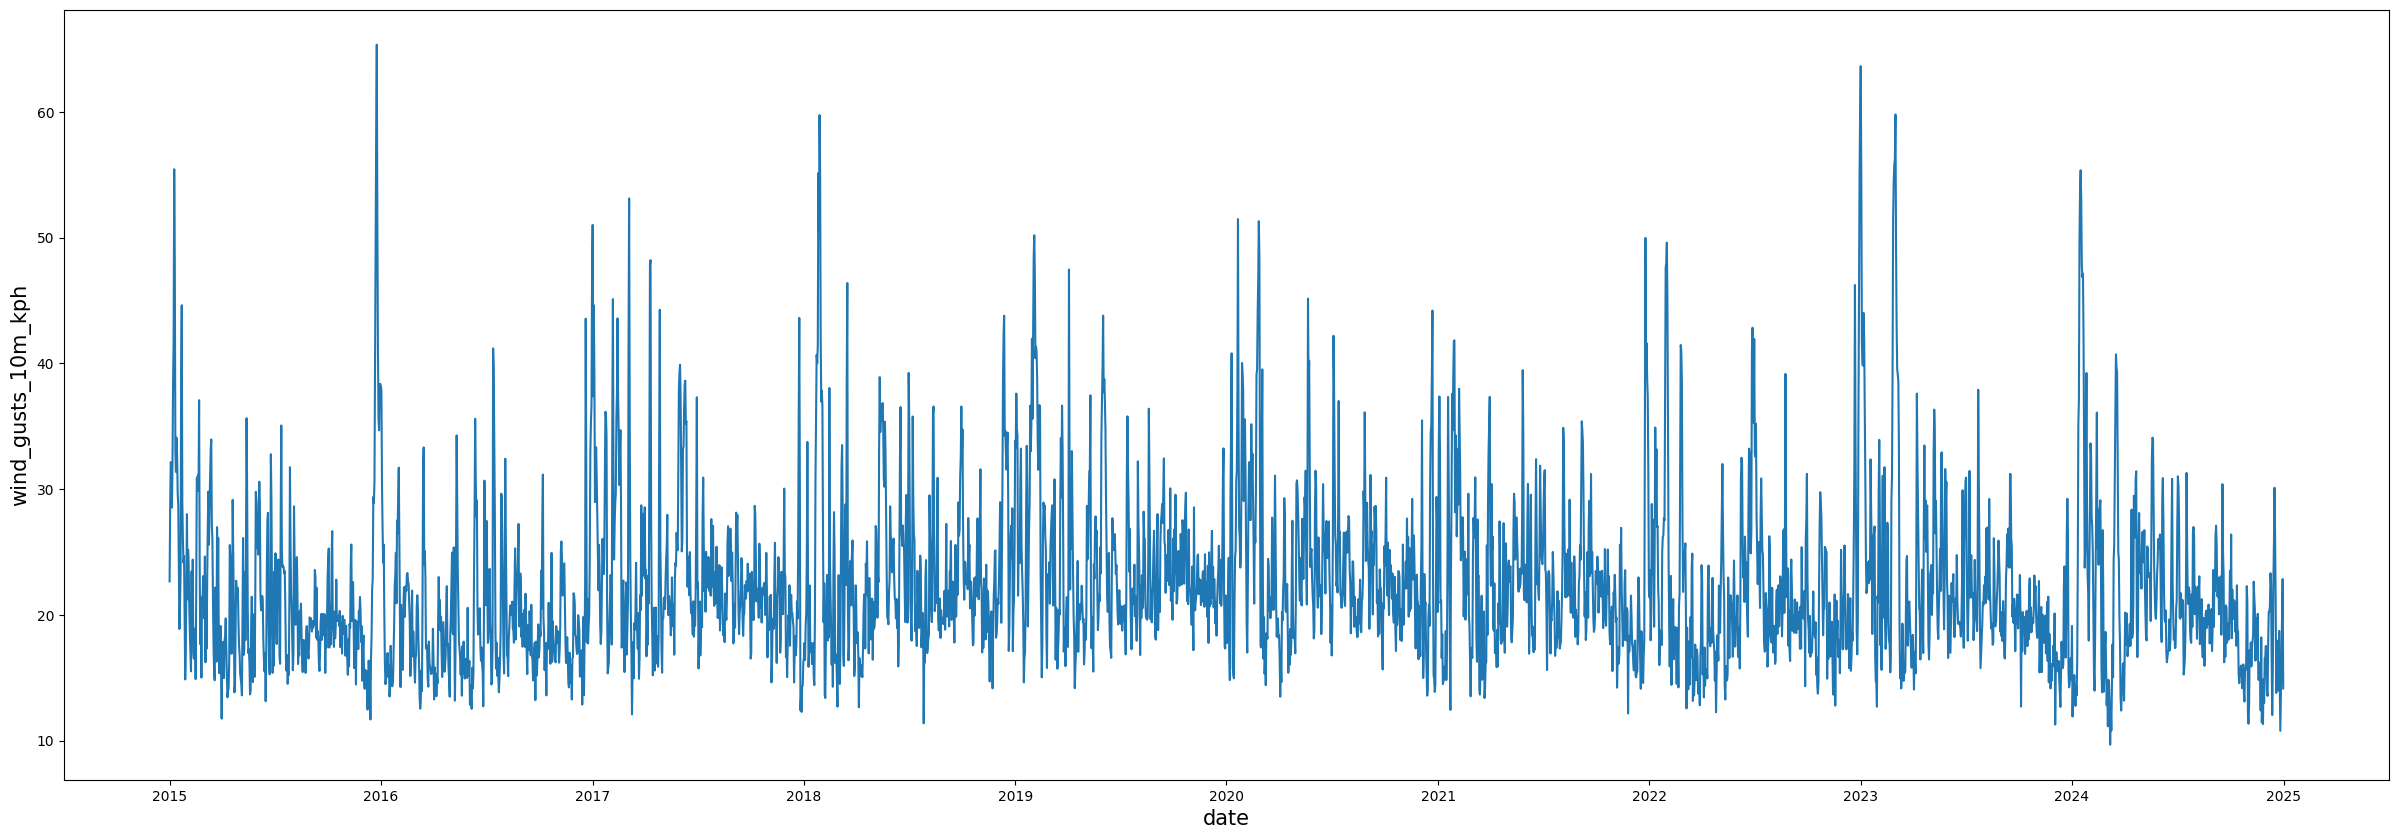

In [122]:
weather_data_b = clean_and_reindex(raw_data_b.copy())

sample_daily_b = weather_data_b.resample("1D").mean()
visualize(sample_daily_b)